In [14]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
from src.utils import (
    process_data_loader,
    print_metrics_in_latex,
    calculate_metrics,
    get_checkpoint_paths,
    mergekfold_results,
    save_normalized_conf_matrices,
    plot_pred_vs_true,
    get_class_dependent_predictions,
    generate_radar_plots,
)
import seaborn as sns
import matplotlib.ticker as ticker
import torch

# Specify the path to your pickle file
file_path = "evaluation_metrics/classification_metrics_list.pkl"
with open(file_path, "rb") as file:
    classification_metrics_list = pickle.load(file)

file_path = "evaluation_metrics/regression_metrics_list.pkl"
with open(file_path, "rb") as file:
    regression_metrics_list = pickle.load(file)

file_path = "evaluation_metrics/collect_classification_results.pkl"
with open(file_path, "rb") as file:
    collect_classification_results = pickle.load(file)

file_path = "evaluation_metrics/collect_regression_results.pkl"
with open(file_path, "rb") as file:
    collect_regression_results = pickle.load(file)

In [15]:
remove_models = [
    "masked-pretraining-noiseless-backbonefrozen",
    "masked-pretraining-noiseless-backbonenotfrozen",
    "clip-finetune",
    "Linear",
    "lc-spectral-meta",
    "lc-meta",
    "noisy",
    "25",
]
pattern = "|".join(remove_models)

classification_metrics_list = pd.DataFrame(classification_metrics_list)
regression_metrics_list = pd.DataFrame(regression_metrics_list)

classification_metrics_list = classification_metrics_list[
    ~classification_metrics_list["Model"].str.contains(pattern)
].reset_index()


regression_metrics_list = regression_metrics_list[
    ~regression_metrics_list["Model"].str.contains(pattern)
].reset_index()

### Prepare data

In [16]:
def calculate_kfold_mean_and_std(metrics_list):
    df = pd.DataFrame(metrics_list)
    numeric_cols = df.select_dtypes(include=[float]).columns
    grouped_df = df.groupby(["id", "Model", "Combination"])[numeric_cols]
    mean_df = grouped_df.mean()
    std_df = grouped_df.std()
    mean_df.reset_index(inplace=True)
    mean_df.drop(columns="id", inplace=True)
    std_df.reset_index(inplace=True)
    std_df.drop(columns="id", inplace=True)
    return mean_df, std_df


# Calculate mean and std from metric using k-folds
class_mean, class_std = calculate_kfold_mean_and_std(classification_metrics_list)
reg_mean, reg_std = calculate_kfold_mean_and_std(regression_metrics_list)

In [17]:
# Prepare raw results
merged_classification = mergekfold_results(collect_classification_results)
merged_regression = mergekfold_results(collect_regression_results)

### Prepare table for paper

In [18]:
import re


def get_best_KNN(mean_df, errors_df, mod):
    # Define a function to remove the KNN part
    def remove_knn(model_name):
        return re.sub(r"\+KNN\d+", "", model_name)

    # Create the Base_Model column by removing the KNN part
    mean_df["Base_Model"] = mean_df["Model"].apply(remove_knn)
    errors_df["Base_Model"] = errors_df["Model"].apply(remove_knn)

    # Group by the base model name and find the row with the maximum 'mac-f1' for each group
    if mod == "class":
        filtered_mean_df = mean_df.loc[
            mean_df.groupby(["Base_Model", "Combination"])["mac-f1"].idxmax()
        ]
    else:
        filtered_mean_df = mean_df.loc[
            mean_df.groupby(["Base_Model", "Combination"])["R2"].idxmax()
        ]

    # Drop the same indices from the errors DataFrame
    filtered_errors_df = errors_df.loc[filtered_mean_df.index]

    # Drop the Base_Model column as it's no longer needed
    filtered_mean_df = filtered_mean_df.drop(columns=["Base_Model"])
    filtered_errors_df = filtered_errors_df.drop(columns=["Base_Model"])

    # Reset index to have a clean DataFrame
    filtered_mean_df = filtered_mean_df.reset_index()
    filtered_errors_df = filtered_errors_df.reset_index()

    return filtered_mean_df, filtered_errors_df

In [19]:
class_mean, class_std = get_best_KNN(class_mean, class_std, "class")
reg_mean, reg_std = get_best_KNN(reg_mean, reg_std, "regress")

In [20]:
classification_metrics_list = pd.DataFrame(classification_metrics_list)
regression_metrics_list = pd.DataFrame(regression_metrics_list)

In [21]:
def make_readable_classification(data):
    df = pd.DataFrame(data)

    # New columns based on specific substrings in 'Model'
    df["sim-pre"] = df["Model"].apply(
        lambda x: ("noiseless" if "noiseless" in x else "noisy" if "noisy" in x else "")
    )

    df["\#Class"] = df["Model"].apply(
        lambda x: (
            "5"
            if "five" in x or "5way" in x
            else "3" if "three" in x or "3way" in x else ""
        )
    )

    df["real-pre"] = df["Model"].apply(
        lambda x: (
            "lc-sp"
            if "clip-real+" in x
            else (
                "lc-sp-m"
                if "lc-spectral-meta" in x
                else (
                    "lc-m"
                    if "lc-meta" in x
                    else (
                        "lc-sp"
                        if "noisy" in x
                        else (
                            "lc-sp"
                            if ("noiseless" in x)
                            and not ("reg" in x)
                            and not ("way" in x)
                            else ""
                        )
                    )
                )
            )
        )
    )
    df["last-layer"] = df["Model"].apply(
        lambda x: (
            "Linear"
            if "Linear" in x
            else (
                "KNN1"
                if "KNN1" in x
                else (
                    "KNN2"
                    if "KNN2" in x
                    else (
                        "KNN3"
                        if "KNN3" in x
                        else (
                            "KNN4"
                            if "KNN4" in x
                            else (
                                "KNN5"
                                if "KNN5" in x
                                else (
                                    "KNN6"
                                    if "KNN6" in x
                                    else (
                                        "KNN7"
                                        if "KNN7" in x
                                        else (
                                            "KNN8"
                                            if "KNN8" in x
                                            else ("KNN9" if "KNN9" in x else "")
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
    df["flatz"] = df["Model"].apply(
        lambda x: (
            "yes"
            if "flatz" in x
            else "no" if "noiseless" in x else "no" if "noisy" in x else " "
        )
    )
    df["pretrained"] = df["Model"].apply(
        lambda x: (
            "clip"
            if "clip" in x and "nois" in x and not ("masked" in x)
            else "masked" if "masked" in x else "no"
        )
    )
    df["masked-pre"] = df["Model"].apply(
        lambda x: ("15\%" if "f15" in x else "25\%" if "f25" in x else " ")
    )
    df["frozen"] = df["Model"].apply(
        lambda x: (
            "no"
            if "backbonenotfrozen" in x
            else "yes" if "backbonefrozen" in x else " "
        )
    )
    # Columns to be placed at the beginning
    priority_columns = [
        "pretrained",
        "last-layer",
        "sim-pre",
        "flatz",
        "real-pre",
        "\#Class",
        "masked-pre",
        "frozen",
        "mac-f1",
    ]

    # Get the remaining columns by excluding the priority ones
    remaining_columns = [col for col in df.columns if col not in priority_columns]

    # Define the new column order
    new_column_order = priority_columns + remaining_columns

    # Reorder the DataFrame columns
    df = df[new_column_order]

    return df


def make_readable_regression(data):
    df = pd.DataFrame(data)

    # New columns based on specific substrings in 'Model'
    df["sim-pre"] = df["Model"].apply(
        lambda x: ("noiseless" if "noise" in x else "noisy" if "noisy" in x else "")
    )

    df["real-pre"] = df["Model"].apply(
        lambda x: (
            "lc-sp"
            if "clip-real+" in x
            else (
                "lc-sp-m"
                if "lc-spectral-meta" in x
                else (
                    "lc-m"
                    if "lc-meta" in x
                    else (
                        "lc-sp"
                        if "noisy" in x
                        else (
                            "lc-sp"
                            if ("noiseless" in x)
                            and not ("reg" in x)
                            and not ("way" in x)
                            else ""
                        )
                    )
                )
            )
        )
    )
    df["last-layer"] = df["Model"].apply(
        lambda x: (
            "Linear"
            if "Linear" in x
            else (
                "KNN1"
                if "KNN1" in x
                else (
                    "KNN2"
                    if "KNN2" in x
                    else (
                        "KNN3"
                        if "KNN3" in x
                        else (
                            "KNN4"
                            if "KNN4" in x
                            else (
                                "KNN5"
                                if "KNN5" in x
                                else (
                                    "KNN6"
                                    if "KNN6" in x
                                    else (
                                        "KNN7"
                                        if "KNN7" in x
                                        else (
                                            "KNN8"
                                            if "KNN8" in x
                                            else ("KNN9" if "KNN9" in x else "")
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
    df["flatz"] = df["Model"].apply(
        lambda x: (
            "yes"
            if "flatz" in x
            else "no" if "noiseless" in x else "no" if "noisy" in x else " "
        )
    )
    df["masked-pre"] = df["Model"].apply(
        lambda x: ("15\%" if "f15" in x else "25\%" if "f25" in x else " ")
    )
    df["frozen"] = df["Model"].apply(
        lambda x: (
            "no"
            if "backbonenotfrozen" in x
            else "yes" if "backbonefrozen" in x else " "
        )
    )
    df["pretrained"] = df["Model"].apply(
        lambda x: (
            "clip"
            if "clip" in x and "nois" in x and not ("masked" in x)
            else "masked" if "masked" in x else "no"
        )
    )
    # Columns to be placed at the beginning
    priority_columns = [
        "pretrained",
        "last-layer",
        "sim-pre",
        "flatz",
        "real-pre",
        "masked-pre",
        "frozen",
        "R2",
    ]

    # Get the remaining columns by excluding the priority ones
    remaining_columns = [col for col in df.columns if col not in priority_columns]

    # Define the new column order
    new_column_order = priority_columns + remaining_columns

    # Reorder the DataFrame columns
    df = df[new_column_order]

    return df


def print_metrics_in_latex(
    metrics_list: List[Dict[str, float]], drop=None, sort=None, make_readable=False
) -> None:
    """
    Generates LaTeX code from a list of metric dictionaries and prints it.

    This function takes a list of dictionaries where each dictionary represents
    performance metrics for a particular model and data combination. It converts
    this list into a DataFrame, formats numerical values to three decimal places,
    and converts the DataFrame to LaTeX format which it then prints.

    Args:
        metrics_list (List[Dict[str, float]]): A list of dictionaries with keys as metric names
                                               and values as their respective numerical values.
        drop: List of columns to drop from the table
        sort: string of column to sort from the table


    Output:
        None: This function directly prints the LaTeX formatted table to the console.
    """
    """
    Generates a LaTeX table from a list of dictionaries containing model metrics,
    formatting the metrics as mean ± standard deviation for each combination and model.
    
    Parameters:
        data (list of dicts): Each dictionary should contain metrics and descriptors such as Model, Combination, and id.

    Returns:
        str: A LaTeX formatted table as a string.
    """
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(metrics_list)

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[float]).columns
    # Ensure that no more than 4 numeric columns are in one table
    max_cols_per_table = 20

    # Calculate mean and standard deviation
    grouped_df = df.groupby(["id", "Model", "Combination"])[numeric_cols]
    mean_df = grouped_df.mean()
    std_df = grouped_df.std()
    # print(mean_df.reset_index().keys())
    # Reset the index and drop 'id'
    mean_df.reset_index(inplace=True)
    mean_df.drop(columns="id", inplace=True)
    std_df.reset_index(inplace=True)
    std_df.drop(columns="id", inplace=True)

    # Get best KNN model
    if "mac-f1" in mean_df.columns:
        mean_df, std_df = get_best_KNN(mean_df, std_df, "class")
    else:
        mean_df, std_df = get_best_KNN(mean_df, std_df, "regress")

    numeric_cols = mean_df.select_dtypes(include=[float]).columns

    # Generate tables
    num_tables = (
        len(numeric_cols) + max_cols_per_table - 1
    ) // max_cols_per_table  # Calculate how many tables are needed
    tables = []

    for i in range(num_tables):
        # Select subset of columns for the current table
        cols_subset = numeric_cols[
            i * max_cols_per_table : (i + 1) * max_cols_per_table
        ]
        summary_df = mean_df[cols_subset].copy()

        # Format 'mean ± std' for each metric in the subset
        for col in cols_subset:
            summary_df[col] = (
                mean_df[col].apply("{:.4f}".format)
                + " ± "
                + std_df[col].apply("{:.4f}".format)
            )
        # Add the non-numerical columns back to summary_df
        non_numerical_cols = mean_df.drop(columns=cols_subset)
        summary_df = pd.concat([non_numerical_cols, summary_df], axis=1)
        summary_df.drop(columns="index", inplace=True)

        if sort is not None:
            if sort in summary_df.columns:
                summary_df.sort_values(by=sort, inplace=True, ascending=False)
        if make_readable:
            if "mac-f1" in summary_df.columns:
                summary_df = make_readable_classification(summary_df)
            else:
                summary_df = make_readable_regression(summary_df)
        if drop is not None:
            summary_df.drop(columns=drop, inplace=True)

        # Generate LaTeX table for the current subset of columns
        latex_table = summary_df.to_latex(
            escape=False,
            column_format="|c" * (len(summary_df.columns)) + "|",
            index=False,
            header=True,
        )
        tables.append(latex_table)
        if not make_readable:
            print(latex_table)
        else:
            print(
                latex_table.replace(
                    "&  &  &   &  &", "& \multicolumn{4}{c|}{end-to-end baseline} & "
                ).replace(
                    "&  &   &   &", "& \multicolumn{3}{c|}{end-to-end baseline} & "
                )
            )

In [31]:
remove_models = ["three", "3way", "masked"]
modality = "lightcurve"
pattern = "|".join(remove_models)

lc_data_only_regress = regression_metrics_list[
    regression_metrics_list["Combination"] == modality
]
lc_data_only_regress = lc_data_only_regress[
    ~lc_data_only_regress["Model"].str.contains(pattern)
].reset_index()

print_metrics_in_latex(
    lc_data_only_regress,
    drop=["Combination", "OLF", "masked-pre", "real-pre", "frozen"],
    sort="R2",
    make_readable=True,
)
#  regression

\begin{tabular}{|c|c|c|c|c|c|c|c|}
\toprule
pretrained & last-layer & sim-pre & flatz & R2 & Model & L1 & L2 \\
\midrule
clip & KNN9 & noiseless & no & 0.6496 ± 0.0398 & clip-noiselesssimpretrain-clipreal+KNN9 & 0.0095 ± 0.0004 & 0.0152 ± 0.0014 \\
clip & KNN9 & noiseless & yes & 0.6283 ± 0.0359 & clip-noiselesssimpretrain-clipreal-flatz+KNN9 & 0.0098 ± 0.0005 & 0.0157 ± 0.0013 \\
no &  &  &   & 0.6129 ± 0.0245 & lc-reg & 0.0104 ± 0.0004 & 0.0160 ± 0.0010 \\
no & KNN9 &  &   & 0.6078 ± 0.0408 & clip-real+KNN9 & 0.0103 ± 0.0006 & 0.0161 ± 0.0014 \\
\bottomrule
\end{tabular}



In [23]:
keep_models = ["lc-reg", "three", "masked"]
modality = "lightcurve"
pattern = "|".join(keep_models)
remove_pretraining = ["frozen"]


lc_data_only_regress = regression_metrics_list[
    regression_metrics_list["Combination"] == modality
]
lc_data_only_regress = lc_data_only_regress[
    lc_data_only_regress["Model"].str.contains(pattern)
].reset_index()

print_metrics_in_latex(
    lc_data_only_regress,
    drop=["Combination", "OLF", "pretrained", "sim-pre"],
    sort="R2",
    make_readable=True,
)
# 3-way masked regression

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\toprule
last-layer & flatz & real-pre & masked-pre & frozen & R2 & Model & L1 & L2 \\
\midrule
 & no &  & 15\% & no & 0.6319 ± 0.0422 & lc-reg-masked-noiseless-f15-backbonenotfrozen & 0.0102 ± 0.0005 & 0.0156 ± 0.0013 \\
 &   & \multicolumn{3}{c|}{end-to-end baseline} &  0.6129 ± 0.0245 & lc-reg & 0.0104 ± 0.0004 & 0.0160 ± 0.0010 \\
 & no &  & 15\% & yes & 0.3658 ± 0.0264 & lc-reg-masked-noiseless-f15-backbonefrozen & 0.0151 ± 0.0005 & 0.0206 ± 0.0015 \\
\bottomrule
\end{tabular}



In [35]:
remove_models = ["five", "5way", "masked"]
modality = "lightcurve"
pattern = "|".join(remove_models)
lc_data_only_class = classification_metrics_list[
    classification_metrics_list["Combination"] == modality
]
lc_data_only_class = lc_data_only_class[
    ~lc_data_only_class["Model"].str.contains(pattern)
].reset_index()


print_metrics_in_latex(
    lc_data_only_class,
    drop=[
        "Combination",
        "mic-p",
        "mic-acc",
        "mic-r",
        "mac-acc",
        "\#Class",
        "mic-f1",
        "masked-pre",
        "frozen",
    ],
    sort="mac-f1",
    make_readable=True,
)
# three way classification nonmasked

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\toprule
pretrained & last-layer & sim-pre & flatz & real-pre & mac-f1 & Model & mac-p & mac-r \\
\midrule
no & \multicolumn{4}{c|}{end-to-end baseline} &  0.7011 ± 0.0303 & lc-3way-f1 & 0.6934 ± 0.0360 & 0.7527 ± 0.0247 \\
clip & KNN8 & noiseless & no & lc-sp & 0.6874 ± 0.0342 & clip-noiselesssimpretrain-clipreal+KNN8+three & 0.8041 ± 0.0833 & 0.6516 ± 0.0216 \\
clip & KNN7 & noiseless & yes & lc-sp & 0.6700 ± 0.0314 & clip-noiselesssimpretrain-clipreal-flatz+KNN7+three & 0.7622 ± 0.0577 & 0.6354 ± 0.0237 \\
no & KNN3 &  &   & lc-sp & 0.6265 ± 0.0231 & clip-real+KNN3+three & 0.6670 ± 0.0532 & 0.6119 ± 0.0121 \\
\bottomrule
\end{tabular}



In [25]:
keep_models = ["3way", "backbone"]
modality = "lightcurve"
remove_models = ["five"]

pattern = "|".join(keep_models)
lc_data_only_class = classification_metrics_list[
    classification_metrics_list["Combination"] == modality
]
lc_data_only_class = lc_data_only_class[
    lc_data_only_class["Model"].str.contains(pattern)
].reset_index()

lc_data_only_class.drop(columns="level_0")

pattern = "|".join(remove_models)
lc_data_only_class = lc_data_only_class[
    ~lc_data_only_class["Model"].str.contains(pattern)
]

print_metrics_in_latex(
    lc_data_only_class,
    drop=[
        "Combination",
        "mic-p",
        "mic-acc",
        "mic-r",
        "mac-acc",
        "sim-pre",
        "flatz",
        "real-pre",
    ],
    sort="mac-f1",
    make_readable=True,
)

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\toprule
pretrained & last-layer & \#Class & masked-pre & frozen & mac-f1 & Model & mic-f1 & mac-p & mac-r \\
\midrule
no &  & 3 &   &   & 0.7011 ± 0.0303 & lc-3way-f1 & 0.8728 ± 0.0205 & 0.6934 ± 0.0360 & 0.7527 ± 0.0247 \\
masked &  & 3 & 15\% & no & 0.6970 ± 0.0246 & lc-3way-f1-masked-noiseless-f15-backbonenotfrozen & 0.8703 ± 0.0211 & 0.6902 ± 0.0287 & 0.7514 ± 0.0217 \\
masked &  & 5 & 15\% & no & 0.5319 ± 0.0470 & lc-5way-f1-masked-noiseless-f15-backbonenotfrozen & 0.8337 ± 0.0294 & 0.5306 ± 0.0585 & 0.5628 ± 0.0457 \\
masked &  & 3 & 15\% & yes & 0.4928 ± 0.0172 & lc-3way-f1-masked-noiseless-f15-backbonefrozen & 0.7788 ± 0.0180 & 0.4945 ± 0.0125 & 0.4992 ± 0.0255 \\
masked &  & 5 & 15\% & yes & 0.3264 ± 0.0285 & lc-5way-f1-masked-noiseless-f15-backbonefrozen & 0.6951 ± 0.0395 & 0.3260 ± 0.0213 & 0.3831 ± 0.0427 \\
\bottomrule
\end{tabular}



### Leaderboard for metrics 

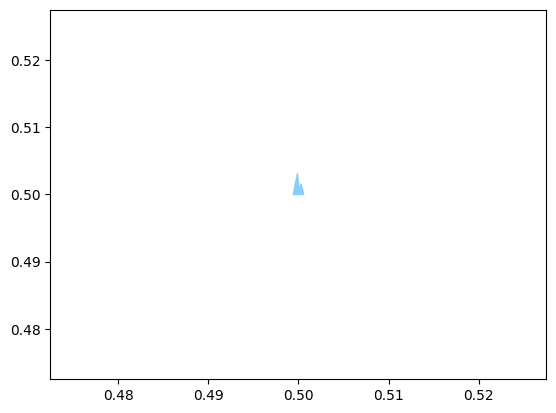

In [26]:
import matplotlib.path as mpath


# Define a custom snowflake marker
def ice_stalactite_marker():
    Path = mpath.Path
    verts = [
        (0.0, 0.0),
        (0.05, 0.2),
        (0.1, 0.0),
        (0.05, 0),
        (0.0, 0.0),
        (-0.025, 0),
        (-0.1, 0.0),
        (-0.022, 0.4),
        (0.025, 0.0),
    ]
    codes = [Path.MOVETO] + [Path.LINETO] * (len(verts) - 1)
    return mpath.Path(verts, codes)


plt.plot(0.5, 0.5, marker=ice_stalactite_marker(), color="lightskyblue", markersize=30)

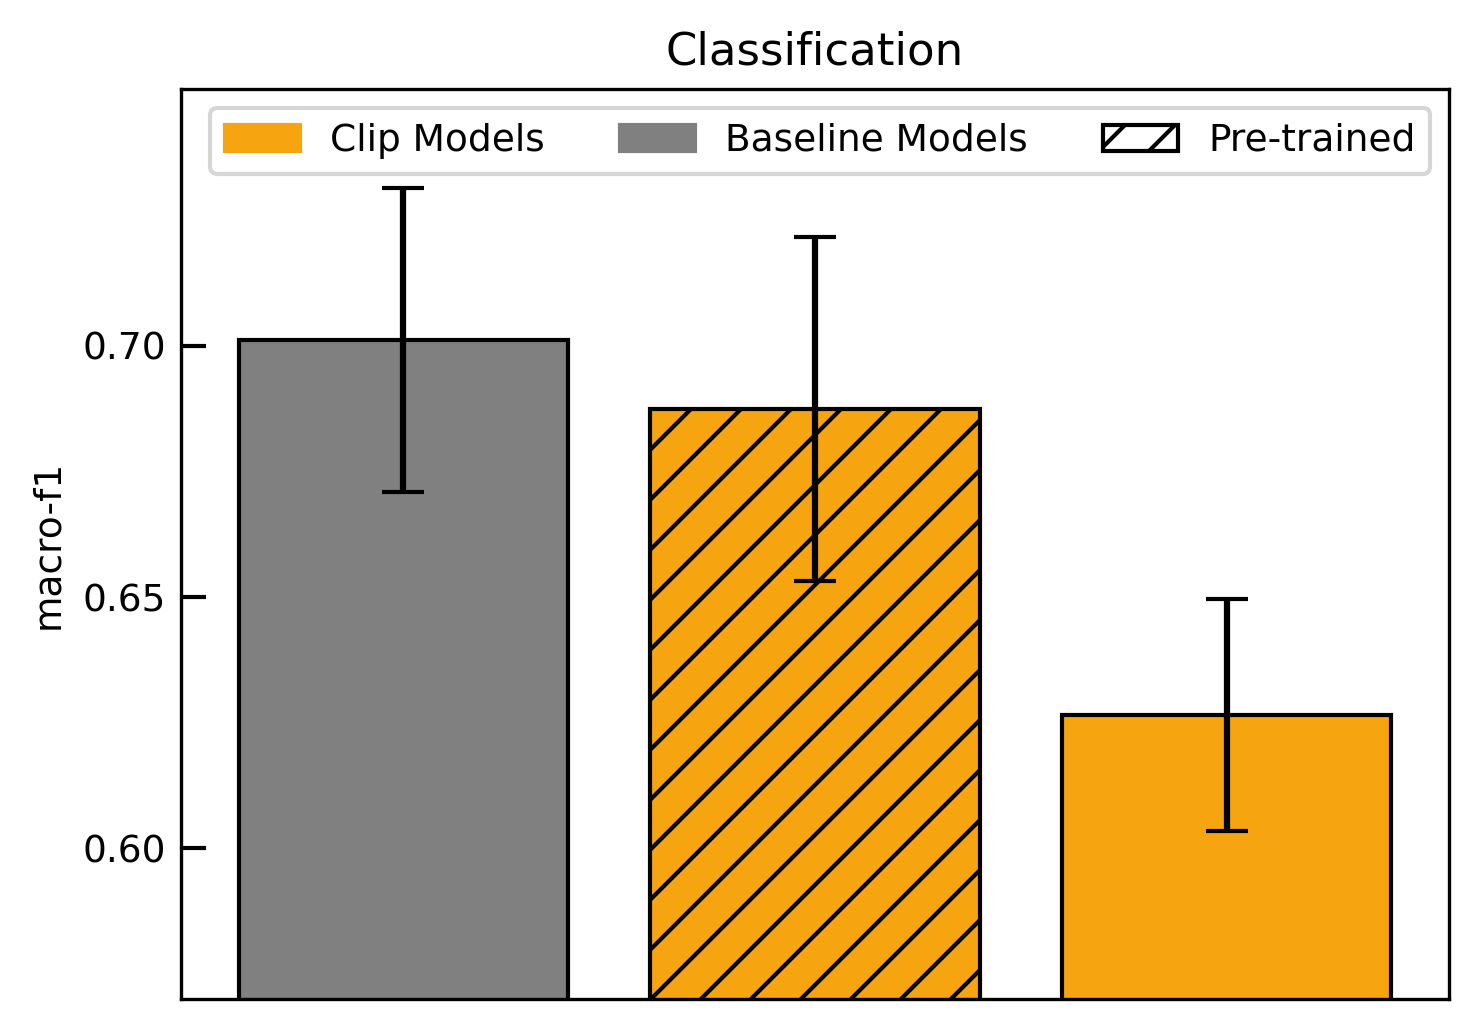

In [59]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.rcParams.update(
    {"font.family": "DejaVu Sans", "font.size": 9}  # Adjust the global font size here
)

# Leaderboard in different metrics for classifications
# ========================
variable_name = "mac-f1"  # Choose from ['mic-f1', 'mic-p', 'mic-r', 'mic-acc', 'mac-f1', 'mac-p', 'mac-r', 'mac-acc']
modality = "lightcurve"
remove_models = [
    "clip-finetune",
    "5way",
    "five",
    "masked",
    "flatz",
]
pattern = "|".join(remove_models)
# ========================

lc_class_mean = class_mean[
    class_mean["Combination"] == modality
]  # .drop(columns=dropcols)
lc_class_std = class_std[
    class_std["Combination"] == modality
]  # .drop(columns=dropcols)
lc_class_mean = lc_class_mean[
    ~lc_class_mean["Model"].str.contains(pattern)
].reset_index()
lc_class_std = lc_class_std[~lc_class_std["Model"].str.contains(pattern)].reset_index()


lc_class_mean = lc_class_mean.sort_values(by=variable_name, ascending=False)
lc_class_std = lc_class_std.loc[lc_class_mean.index]

KNNColor = "#f6a410"
LinearColor = "#207394"
LightcurveColor = "#ffd510"
SpectralColor = "#e64110"
MetaColor = "#5a9c39"
divisionLine = "#084153"

colors = [
    (
        KNNColor
        if "KNN" in model
        else (
            LinearColor
            if "Linear" in model
            else "gray" if (model == "lc-3way-f1" or model == "lc-5way-f1") else "white"
        )
    )
    for model in lc_class_mean["Model"]
]
hatches = [
    "//" if "noiseless" in model else "\\\\" if "noisy" in model else ""
    for model in lc_class_mean["Model"]
]  # hatching for 'nois'

edgewidths = [2 if "flatz" in model else 1 for model in lc_class_mean["Model"]]

edgecolors = [
    "red" if "masked" in model else "black" for model in lc_class_mean["Model"]
]

plt.figure(figsize=(5, 3.5), dpi=300)
bars = plt.bar(
    lc_class_mean["Model"],
    lc_class_mean[variable_name],
    yerr=lc_class_std[variable_name],
    capsize=5,
    color=colors,
    hatch=hatches,
    edgecolor=edgecolors,
    linewidth=edgewidths,
)
maxhight = max(lc_class_mean[variable_name]) + 0.05
minhight = min(lc_class_mean[variable_name]) - 0.2

# Enhance bars for 'meta' models with thicker edges and a top cap
# Place a gold diamond marker in the middle of bars for 'meta' models

for bar, model in zip(bars, lc_class_mean["Model"]):
    if "three" in model or "3way" in model:
        height = 0.4
    else:
        height = 0.27
    """
    if "f1" not in model:
        plt.plot(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.05,
            "h",
            color=LightcurveColor,
            markersize=10,
        )  # Mid-bar gold diamond
    if ("sp" in model or "nois" in model) and ("masked" not in model):
        plt.plot(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            "*",
            color=SpectralColor,
            markersize=12,
        )  # Mid-bar gold diamond
    if "meta" in model:
        plt.plot(
            bar.get_x() + bar.get_width() / 2.0,
            height - 0.05,
            "D",
            color=MetaColor,
            markersize=9,
        )  # Mid-bar gold diamond
    """
    if "backbonefrozen" in model:
        plt.plot(
            bar.get_x() + bar.get_width() / 2.0,
            height - 0.2,
            marker=ice_stalactite_marker(),
            color="lightskyblue",
            markersize=24,
        )

# Locate the model just before the maximum 'lc-5way-f1' value
line_position = (
    lc_class_mean["Model"] == "lc-5way-f1"
).argmax() - 0.5  # Set line just before the maximum

"""
# Add a vertical red dotted line before the identified model
plt.axvline(x=line_position, color=divisionLine, linestyle="--", linewidth=2)


# Add annotations with arrows parallel to the x-axis
plt.annotate(
    "3 classes",
    xy=(line_position - 5, maxhight - 0.05),
    xytext=(line_position - 2, maxhight - 0.05),
    arrowprops=dict(arrowstyle="->", color="black"),
    va="center",
)

plt.annotate(
    "5 classes",
    xy=(line_position + 5.0, maxhight - 0.05),
    xytext=(line_position + 0.15, maxhight - 0.05),
    arrowprops=dict(arrowstyle="->", color="black"),
    va="center",
)
"""

frozen_marker = mlines.Line2D(
    [],
    [],
    color="lightskyblue",
    marker=ice_stalactite_marker(),
    linestyle="None",
    markersize=24,
    label="frozen backbone",
)

red_patch = mpatches.Patch(color=KNNColor, label="Clip Models")
base_patch = mpatches.Patch(color="red", alpha=0.2, label="Baseline")
# blue_patch = mpatches.Patch(color=LinearColor, label="Linear Models")
gray_patch = mpatches.Patch(color="gray", label="Baseline Models")
noisless_hatch_patch = mpatches.Patch(
    facecolor="white", edgecolor="black", hatch="//", label="Pre-trained"
)
# noisy_hatch_patch = mpatches.Patch(
#    facecolor="white", edgecolor="black", hatch="\\\\", label="noisy Pretrained"
# )
flatz_edge_patch = mpatches.Patch(
    facecolor="white", edgecolor="black", linewidth=2, label="flat-z simulations"
)
masked_patch = mpatches.Patch(
    facecolor="white", edgecolor="red", linewidth=1, label="masked pretraining"
)
lc_marker = mlines.Line2D(
    [],
    [],
    color=LightcurveColor,
    marker="h",
    linestyle="None",
    markersize=10,
    label="lightcurve",
)
sp_marker = mlines.Line2D(
    [],
    [],
    color=SpectralColor,
    marker="*",
    linestyle="None",
    markersize=12,
    label="spectral",
)
meta_marker = mlines.Line2D(
    [], [], color=MetaColor, marker="D", linestyle="None", markersize=9, label="meta"
)

plt.legend(
    handles=[
        red_patch,
        #       base_patch,
        #       blue_patch,
        gray_patch,
        noisless_hatch_patch,
        #       noisy_hatch_patch,
        #       lc_marker,
        #       sp_marker,
        #       meta_marker,
        #       flatz_edge_patch,
        #       frozen_marker,
        #       masked_patch,
    ],
    ncols=4,
    loc="upper right",
    #   bbox_to_anchor=(0.5, -0.05),
)


# Set ticks to be inward facing
plt.tick_params(axis="both", which="both", direction="in", length=6, width=1)


plt.ylim([minhight, maxhight])
# plt.xlabel("Model")
plt.ylabel("macro-f1")
# plt.title(f"{variable_name} for lightcurve classifcation")
plt.xticks(rotation=45, ha="right")
plt.xticks([])
plt.ylim(ymin=0.57)
plt.yticks([0.6, 0.65, 0.7])
plt.title("Classification")
plt.tight_layout()
plt.savefig("overview-f1.pdf")

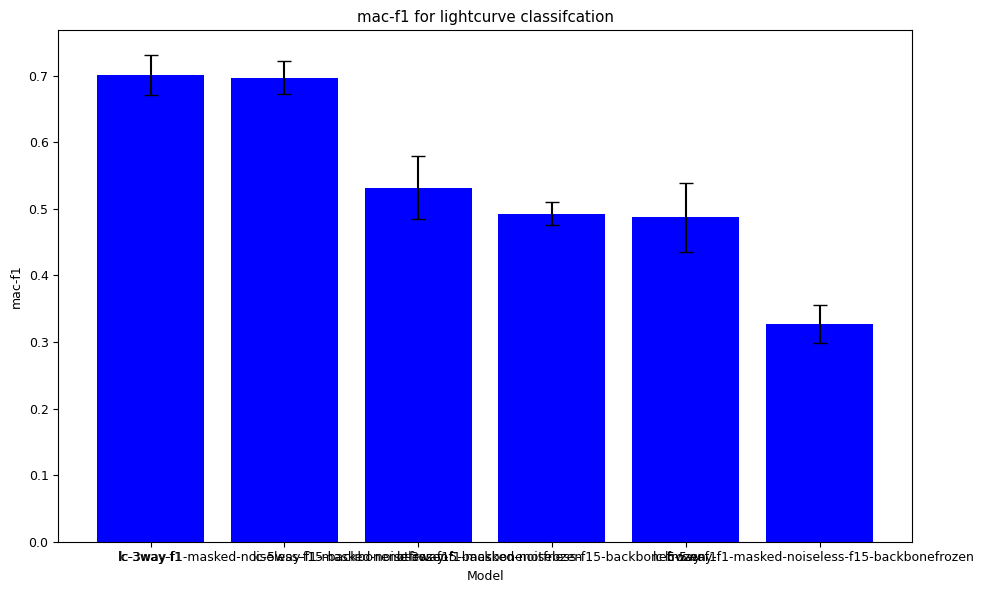

In [17]:
# Leaderboard in different metrics for classifications
# ========================
variable_name = "mac-f1"  # Choose from ['mic-f1', 'mic-p', 'mic-r', 'mic-acc', 'mac-f1', 'mac-p', 'mac-r', 'mac-acc']
modality = "lightcurve"
remove_models = ["f1"]
pattern = "|".join(remove_models)

# ========================

lc_class_mean = class_mean[
    class_mean["Combination"] == modality
]  # .drop(columns=dropcols)
lc_class_std = class_std[
    class_std["Combination"] == modality
]  # .drop(columns=dropcols)
lc_class_mean = lc_class_mean[
    lc_class_mean["Model"].str.contains(pattern)
].reset_index()
lc_class_std = lc_class_std[lc_class_std["Model"].str.contains(pattern)].reset_index()


lc_class_mean = lc_class_mean.sort_values(by=variable_name, ascending=False)
lc_class_std = lc_class_std.loc[lc_class_mean.index]
plt.figure(figsize=(10, 6), dpi=100)
plt.bar(
    lc_class_mean["Model"],
    lc_class_mean[variable_name],
    yerr=lc_class_std[variable_name],
    capsize=5,
    color="blue",
)
# plt.ylim([0.7, 0.95])
plt.xlabel("Model")
plt.ylabel(variable_name)
plt.title(f"{variable_name} for lightcurve classifcation")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
# plt.ylim(0.55,0.75)

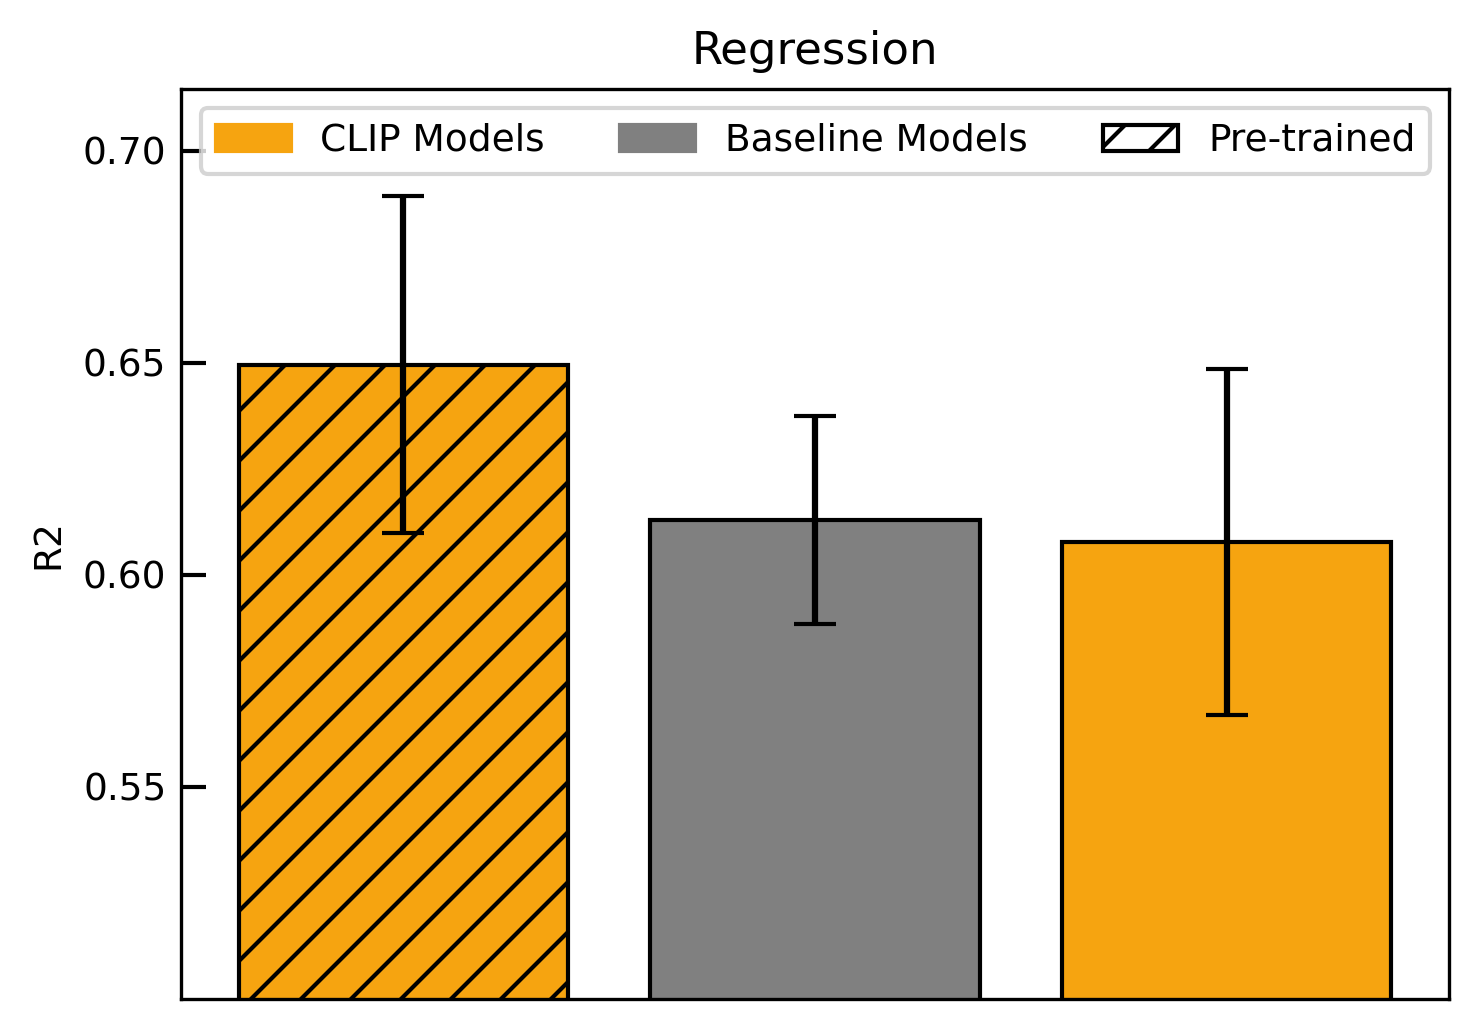

In [61]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.rcParams.update(
    {"font.family": "DejaVu Sans", "font.size": 9}  # Adjust the global font size here
)

# Leaderboard in different metrics for classifications
# ========================
variable_name = "R2"  # Choose [ L1	L2	R2	OLF]
modality = "lightcurve"
remove_models = ["clip-finetune", "masked", "flatz"]
pattern = "|".join(remove_models)
# ========================

lc_reg_mean = reg_mean[reg_mean["Combination"] == modality]  # .drop(columns=dropcols)
lc_reg_std = reg_std[reg_std["Combination"] == modality]  # .drop(columns=dropcols)
lc_reg_mean = lc_reg_mean[~lc_reg_mean["Model"].str.contains(pattern)].reset_index()
lc_reg_std = lc_reg_std[~lc_reg_std["Model"].str.contains(pattern)].reset_index()


lc_reg_mean = lc_reg_mean.sort_values(by=variable_name, ascending=False)
lc_reg_std = lc_reg_std.loc[lc_reg_mean.index]


KNNColor = "#f6a410"
LinearColor = "#207394"
LightcurveColor = "#ffd510"
SpectralColor = "#e64110"
MetaColor = "#5a9c39"
divisionLine = "#084153"

colors = [
    (
        KNNColor
        if "KNN" in model
        else (
            LinearColor
            if "Linear" in model
            else "gray" if (model == "lc-reg") else "white"
        )
    )
    for model in lc_reg_mean["Model"]
]
hatches = [
    "//" if "noiseless" in model else "\\\\" if "noisy" in model else ""
    for model in lc_reg_mean["Model"]
]  # hatching for 'nois'

edgewidths = [2 if "flatz" in model else 1 for model in lc_reg_mean["Model"]]

edgecolors = ["red" if "masked" in model else "black" for model in lc_reg_mean["Model"]]

plt.figure(figsize=(5, 3.5), dpi=300)
bars = plt.bar(
    lc_reg_mean["Model"],
    lc_reg_mean[variable_name],
    yerr=lc_reg_std[variable_name],
    capsize=5,
    color=colors,
    hatch=hatches,
    edgecolor=edgecolors,
    linewidth=edgewidths,
)
maxhight = max(lc_reg_mean[variable_name]) * 1.1
minhight = 0  # min(lc_reg_mean[variable_name]) * 0.3

# Enhance bars for 'meta' models with thicker edges and a top cap
# Place a gold diamond marker in the middle of bars for 'meta' models
for bar, model in zip(bars, lc_reg_mean["Model"]):
    height = 0.4
    """
    if "f1" not in model:
        plt.plot(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.05,
            "h",
            color=LightcurveColor,
            markersize=10,
        )  # Mid-bar gold diamond
    if ("sp" in model or "noise" in model) and not ("masked" in model):
        plt.plot(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            "*",
            color=SpectralColor,
            markersize=12,
        )  # Mid-bar gold diamond
    if "meta" in model:
        plt.plot(
            bar.get_x() + bar.get_width() / 2.0,
            height - 0.05,
            "D",
            color=MetaColor,
            markersize=9,
        )  # Mid-bar gold diamond
    if "backbonefrozen" in model:
        plt.plot(
            bar.get_x() + bar.get_width() / 2.0,
            height - 0.3,
            marker=ice_stalactite_marker(),
            color="lightskyblue",
            markersize=24,
        )
    """
# Locate the model just before the maximum 'lc-5way-f1' value
line_position = (
    lc_class_mean["Model"] == "lc-5way-f1"
).argmax() - 0.5  # Set line just before the maximum


# Create legend
frozen_marker = mlines.Line2D(
    [],
    [],
    color="lightskyblue",
    marker=ice_stalactite_marker(),
    linestyle="None",
    markersize=24,
    label="frozen backbone",
)
red_patch = mpatches.Patch(color=KNNColor, label="CLIP Models")
base_patch = mpatches.Patch(color="red", alpha=0.2, label="Baseline")
blue_patch = mpatches.Patch(color=LinearColor, label="Linear Models")
gray_patch = mpatches.Patch(color="gray", label="Baseline Models")
noisless_hatch_patch = mpatches.Patch(
    facecolor="white", edgecolor="black", hatch="//", label="Pre-trained"
)
noisy_hatch_patch = mpatches.Patch(
    facecolor="white", edgecolor="black", hatch="\\\\", label="noisy Pretrained"
)
flatz_edge_patch = mpatches.Patch(
    facecolor="white", edgecolor="black", linewidth=2, label="flat-z simulations"
)
masked_patch = mpatches.Patch(
    facecolor="white", edgecolor="red", linewidth=1, label="masked pretraining"
)
lc_marker = mlines.Line2D(
    [],
    [],
    color=LightcurveColor,
    marker="h",
    linestyle="None",
    markersize=10,
    label="lightcurve",
)
sp_marker = mlines.Line2D(
    [],
    [],
    color=SpectralColor,
    marker="*",
    linestyle="None",
    markersize=12,
    label="spectral",
)
meta_marker = mlines.Line2D(
    [], [], color=MetaColor, marker="D", linestyle="None", markersize=9, label="meta"
)

plt.legend(
    handles=[
        red_patch,
        #        base_patch,
        #        blue_patch,
        gray_patch,
        noisless_hatch_patch,
        #        noisy_hatch_patch,
        #        lc_marker,
        #        sp_marker,
        ##        meta_marker,
        #        flatz_edge_patch,
        ##        frozen_marker,
        #        masked_patch,
    ],
    ncols=4,
    loc="upper right",
    #  bbox_to_anchor=(0.5, -0.05),
)


# Set ticks to be inward facing
plt.tick_params(axis="both", which="both", direction="in", length=6, width=1)

ref_val_std = lc_reg_std[variable_name][lc_reg_std["Model"] == "lc-reg"].item()
ref_val = lc_reg_mean[variable_name][lc_reg_mean["Model"] == "lc-reg"].item()
# plt.axhline(y=ref_val, color="r", linestyle="--")
# plt.axhspan(
#    ref_val - ref_val_std,
##    ref_val + ref_val_std,
#    color="red",
#    alpha=0.2,
#    label="Region between y=9 and y=11",
# )


plt.ylim([minhight, maxhight])
# plt.xlabel("Model")
plt.ylabel(variable_name)
# plt.title(f"{variable_name} for lightcurve classifcation")
plt.xticks(rotation=45, ha="right")
plt.xticks([])
plt.yticks([0.55, 0.6, 0.65, 0.7])
plt.title("Regression")
plt.tight_layout()
plt.ylim(ymin=0.5)
plt.savefig(f"overview-{variable_name}.pdf")

(0.2, 0.7)

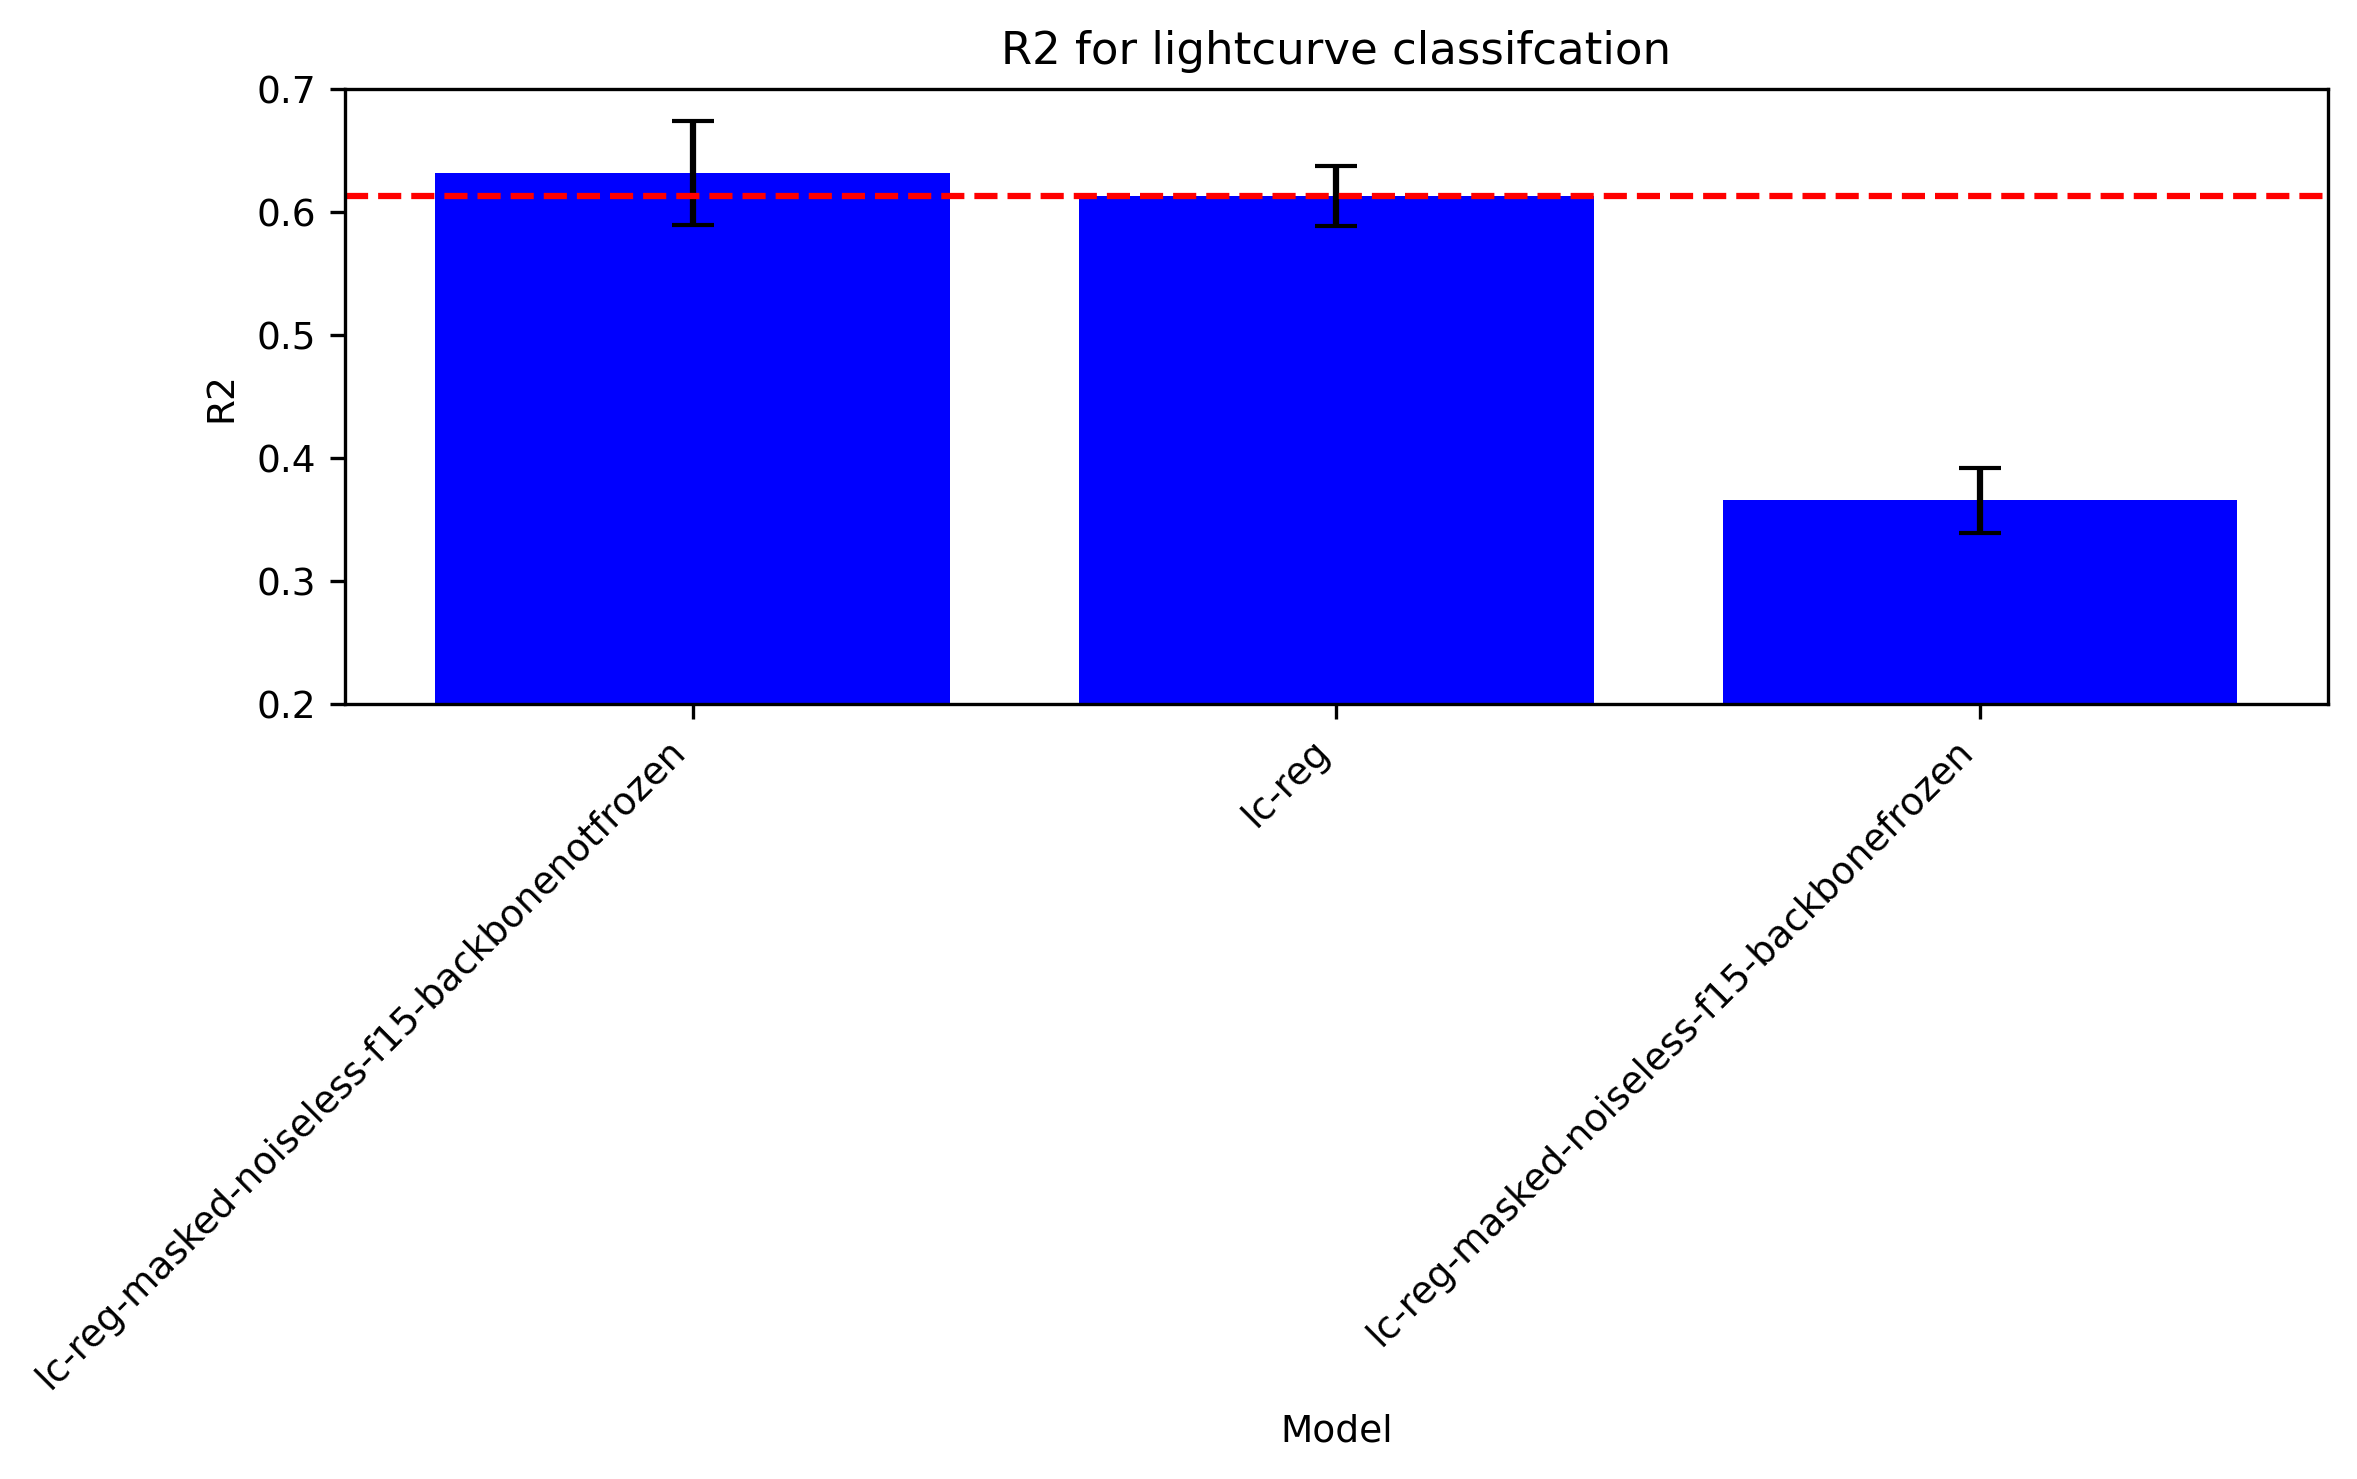

In [19]:
# ========================
variable_name = "R2"  # Choose [ L1	L2	R2	OLF]
modality = "lightcurve"
class_filter = 4.0
remove_models = ["lc-reg", "masked"]
pattern = "|".join(remove_models)
# Remove rows where the 'Model' column contains any of the strings in remove_models

# ========================

lc_reg_mean = reg_mean[reg_mean["Combination"] == modality]  # .drop(columns=dropcols)
lc_reg_std = reg_std[reg_std["Combination"] == modality]  # .drop(columns=dropcols)
lc_reg_mean = lc_reg_mean[lc_reg_mean["Model"].str.contains(pattern)].reset_index()
lc_reg_std = lc_reg_std[lc_reg_std["Model"].str.contains(pattern)].reset_index()

lc_reg_mean = lc_reg_mean.sort_values(by=variable_name, ascending=False)
lc_reg_std = lc_reg_std.loc[lc_reg_mean.index]
plt.figure(figsize=(8, 5), dpi=300)
plt.bar(
    lc_reg_mean["Model"],
    lc_reg_mean[variable_name],
    yerr=lc_reg_std[variable_name],
    capsize=5,
    color="blue",
)
ref_val = lc_reg_mean[variable_name][lc_reg_mean["Model"] == "lc-reg"].item()
plt.axhline(y=ref_val, color="r", linestyle="--", label="y=10")

plt.xlabel("Model")
plt.ylabel(variable_name)
plt.title(f"{variable_name} for lightcurve classifcation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.ylim(0.2, 0.7)

### Classification results analysis - Analysis of redshift of rightly classified SN

In [20]:
def filter_elements(df, target_class):
    """
    Filters the DataFrame to include only rows where the specified target class is present.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing model predictions and true labels.
    target_class (float): The target class to filter for.

    Returns:
    pd.DataFrame: A DataFrame containing the filtered cases for the specified target class.
    """
    # Ensure the original 'y_pred' is kept intact for reference
    df["y_pred_all"] = df["y_true"]

    # Function to apply the mask within the arrays
    def filter_arrays(row):
        indices_pos_class = [
            i
            for i, (pred, true_label) in enumerate(
                zip(row["y_pred"], row["y_true_label"])
            )
            if pred == target_class and true_label == target_class
        ]
        indices_all = [
            i
            for i, true_label in enumerate(row["y_true_label"])
            if true_label == target_class
        ]
        indices_neg_class = [
            i
            for i, (pred, true_label) in enumerate(
                zip(row["y_pred"], row["y_true_label"])
            )
            if pred != target_class and true_label == target_class
        ]
        filtered_lc_data_all = (
            {
                key: [row["lc_data"][key][i] for i in indices_all]
                for key in row["lc_data"]
            }
            if "lc_data" in row
            else None
        )
        filtered_lc_data_pos = (
            {
                key: [row["lc_data"][key][i] for i in indices_pos_class]
                for key in row["lc_data"]
            }
            if "lc_data" in row
            else None
        )
        filtered_lc_data_neg = (
            {
                key: [row["lc_data"][key][i] for i in indices_neg_class]
                for key in row["lc_data"]
            }
            if "lc_data" in row
            else None
        )

        return {
            "y_pred": [row["y_pred"][i] for i in indices_pos_class],
            "y_true": [row["y_true"][i] for i in indices_pos_class],
            "y_true_label": [row["y_true_label"][i] for i in indices_pos_class],
            "y_pred_all": [row["y_pred_all"][i] for i in indices_all],
            "lc_data_all": filtered_lc_data_all,
            "lc_data": filtered_lc_data_pos,
            "lc_data_not": filtered_lc_data_neg,
        }

    # Apply the function to each row in the DataFrame
    filtered_data = df.apply(filter_arrays, axis=1)

    # Create a new DataFrame from the filtered data
    result_df = pd.DataFrame(filtered_data.tolist(), index=df.index)

    # Handle the lc_data separately to avoid column overlap
    lc_data_filtered = result_df.pop("lc_data")

    # Combine the filtered arrays back with the original DataFrame
    final_df = df.drop(columns=["y_pred", "y_true", "y_true_label", "y_pred_all"]).join(
        result_df
    )

    # Add the lc_data back to the final DataFrame
    final_df["lc_data"] = lc_data_filtered

    return final_df.reset_index(drop=True)

Filter out the models you want to compare the redshift distribtion

In [21]:
class_filter = 4.0
remove_models = ["three", "3way", "Linear", "noisy", "5way", "clip-real"]
"""
remove_models = [
    "three",
    "3way",
    "Linear",
]  
"""
lc_merged_classification = merged_classification[
    merged_classification["Combination"] == "lightcurve"
]

# Create a regex pattern from the list of strings
pattern = "|".join(remove_models)

if "three" in remove_models:
    class_names = {
        0: ("SLSN-I", "blue"),
        1: ("SN II", "green"),
        2: ("SN IIn", "teal"),
        3: ("SN Ia", "purple"),
        4: ("SN Ibc", "orange"),
    }
else:
    class_names = {
        0: ("SN II", "green"),
        1: ("SN Ia", "purple"),
        2: ("SN Ibc", "orange"),
    }

# Remove rows where the 'Model' column contains any of the strings in remove_models
df_cleaned = lc_merged_classification[
    ~lc_merged_classification["Model"].str.contains(pattern)
].reset_index()
print("We will work with these models: ")
print(df_cleaned[["Model", "Combination"]])
print(f"and we will remove class {class_names[int(class_filter)][0]}")

We will work with these models: 
                                                Model Combination
0                             clip-finetune+KNN1+five  lightcurve
1                             clip-finetune+KNN2+five  lightcurve
2                             clip-finetune+KNN3+five  lightcurve
3                             clip-finetune+KNN5+five  lightcurve
4                             clip-finetune+KNN7+five  lightcurve
5                             clip-finetune+KNN8+five  lightcurve
6                             clip-finetune+KNN9+five  lightcurve
7        clip-noiselesssimpretrain-clipreal+KNN1+five  lightcurve
8        clip-noiselesssimpretrain-clipreal+KNN2+five  lightcurve
9        clip-noiselesssimpretrain-clipreal+KNN3+five  lightcurve
10       clip-noiselesssimpretrain-clipreal+KNN5+five  lightcurve
11       clip-noiselesssimpretrain-clipreal+KNN7+five  lightcurve
12       clip-noiselesssimpretrain-clipreal+KNN8+five  lightcurve
13       clip-noiselesssimpretrain-clipreal

<Figure size 1000x600 with 0 Axes>

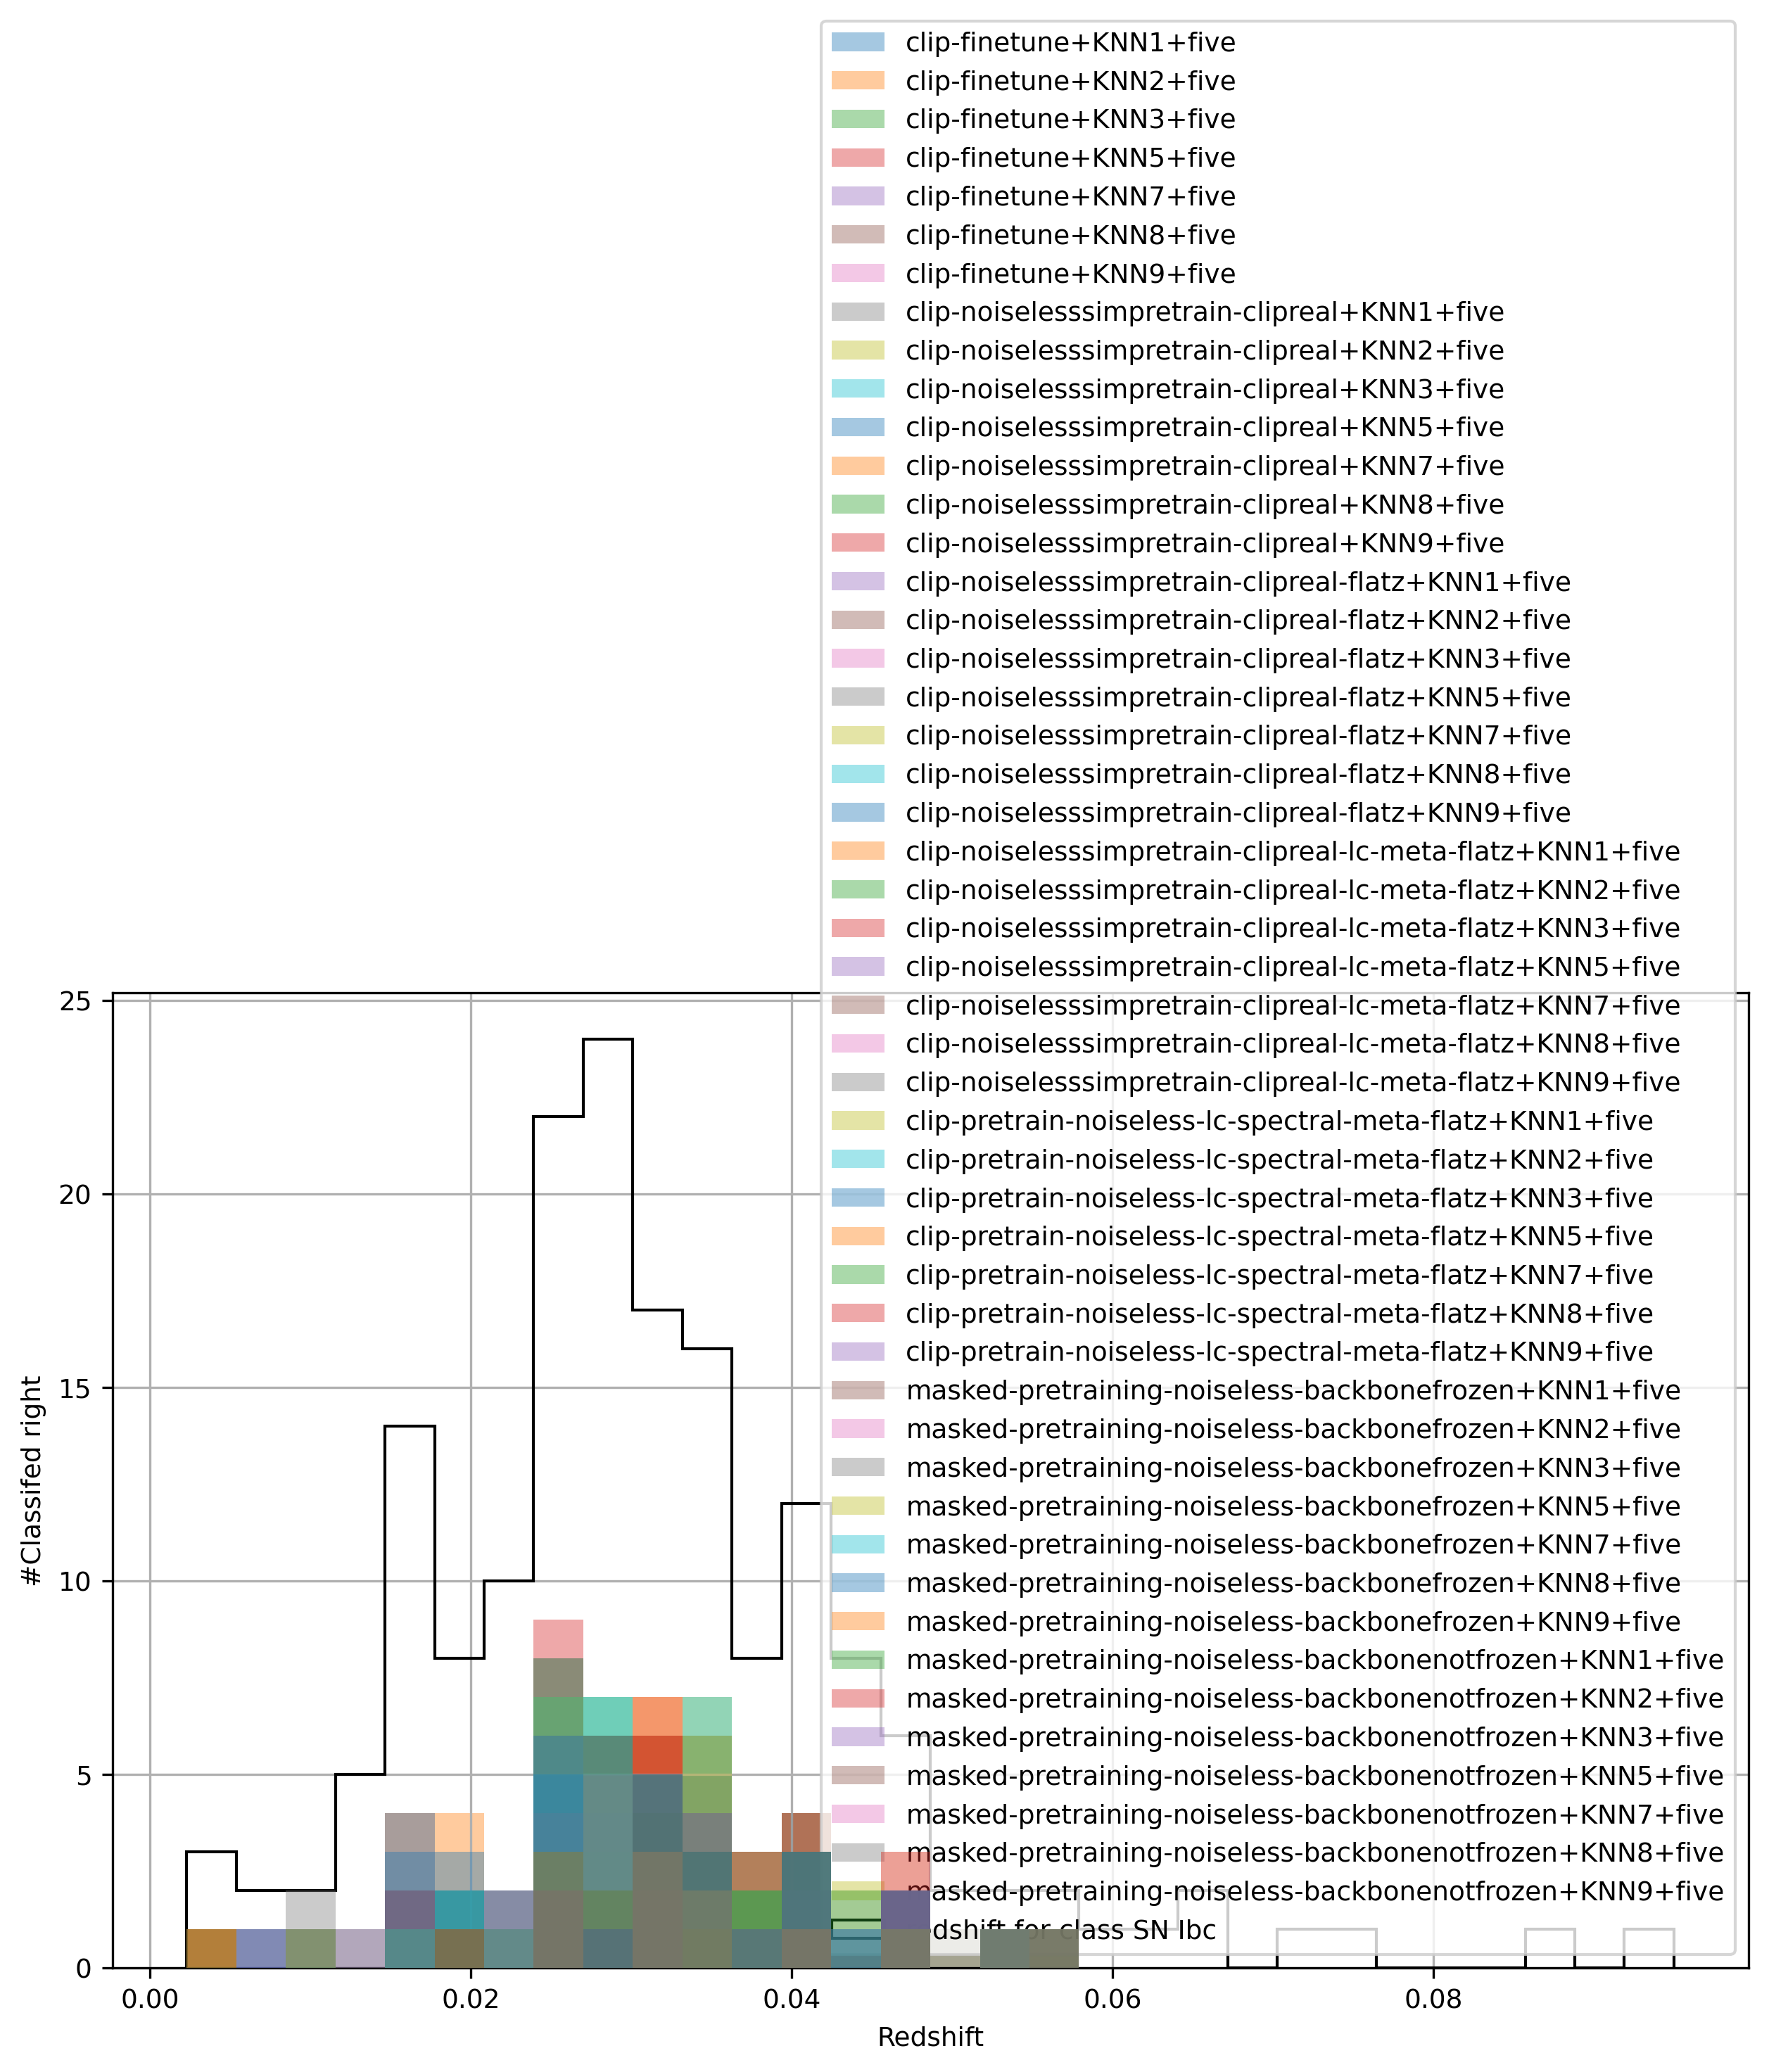

In [22]:
# Filter out classes
filtered_classified = filter_elements(df_cleaned, class_filter)

plt.figure(figsize=(10, 6))

# Determine the number of subplots needed
fig = plt.figure(figsize=(10, 6), dpi=300)
total_class_hist = filtered_classified["y_pred_all"][0]

for i, (index, row) in enumerate(filtered_classified.iterrows()):
    plt.hist(
        row["y_true"],
        bins=30,
        label=row["Model"],
        range=[min(total_class_hist), max(total_class_hist)],
        alpha=0.4,
        zorder=20 - i,
    )
plt.hist(
    total_class_hist,
    color="black",
    edgecolor="black",
    bins=30,
    range=[min(total_class_hist), max(total_class_hist)],
    label=f"redshift for class {class_names[int(class_filter)][0]}",
    histtype="step",
)
plt.xlabel("Redshift")
plt.ylabel("#Classifed right")
plt.legend()
plt.grid(True)

plt.savefig("redshiftmissclass.pdf")
plt.show()

In [23]:
def compute_masked_min(filtered_df, data="lc_data"):
    """
    Computes the minimum of x_lc after applying mask_lc for each batch.

    Parameters:
    filtered_df (pd.DataFrame): The filtered DataFrame containing 'lc_data' with 'x_lc' and 'mask_lc'.

    Returns:
    List: A list containing the masked minimum values for each batch.
    """
    x_lc_list = filtered_df[data].apply(lambda d: d["x_lc"] if d is not None else None)
    mask_lc_list = filtered_df[data].apply(
        lambda d: d["mask_lc"] if d is not None else None
    )
    masked_min_list = []

    for x_lc, mask_lc in zip(x_lc_list, mask_lc_list):
        if x_lc is not None and len(x_lc) > 0:
            masked_min = np.min(np.where(mask_lc, x_lc, np.inf), axis=1)
            masked_min_list.append(masked_min)
        else:
            masked_min_list.append([])

    return masked_min_list

In [24]:
# Filter out classes
filtered_classified = filter_elements(df_cleaned, class_filter)
min_lc_data_hit = compute_masked_min(filtered_classified, "lc_data")
min_lc_data_class_all = compute_masked_min(filtered_classified, "lc_data_all")
min_lc_data_miss = compute_masked_min(filtered_classified, "lc_data_not")

In [25]:
filtered_classified["Model"]

0                               clip-finetune+KNN1+five
1                               clip-finetune+KNN2+five
2                               clip-finetune+KNN3+five
3                               clip-finetune+KNN5+five
4                               clip-finetune+KNN7+five
5                               clip-finetune+KNN8+five
6                               clip-finetune+KNN9+five
7          clip-noiselesssimpretrain-clipreal+KNN1+five
8          clip-noiselesssimpretrain-clipreal+KNN2+five
9          clip-noiselesssimpretrain-clipreal+KNN3+five
10         clip-noiselesssimpretrain-clipreal+KNN5+five
11         clip-noiselesssimpretrain-clipreal+KNN7+five
12         clip-noiselesssimpretrain-clipreal+KNN8+five
13         clip-noiselesssimpretrain-clipreal+KNN9+five
14    clip-noiselesssimpretrain-clipreal-flatz+KNN1+...
15    clip-noiselesssimpretrain-clipreal-flatz+KNN2+...
16    clip-noiselesssimpretrain-clipreal-flatz+KNN3+...
17    clip-noiselesssimpretrain-clipreal-flatz+K

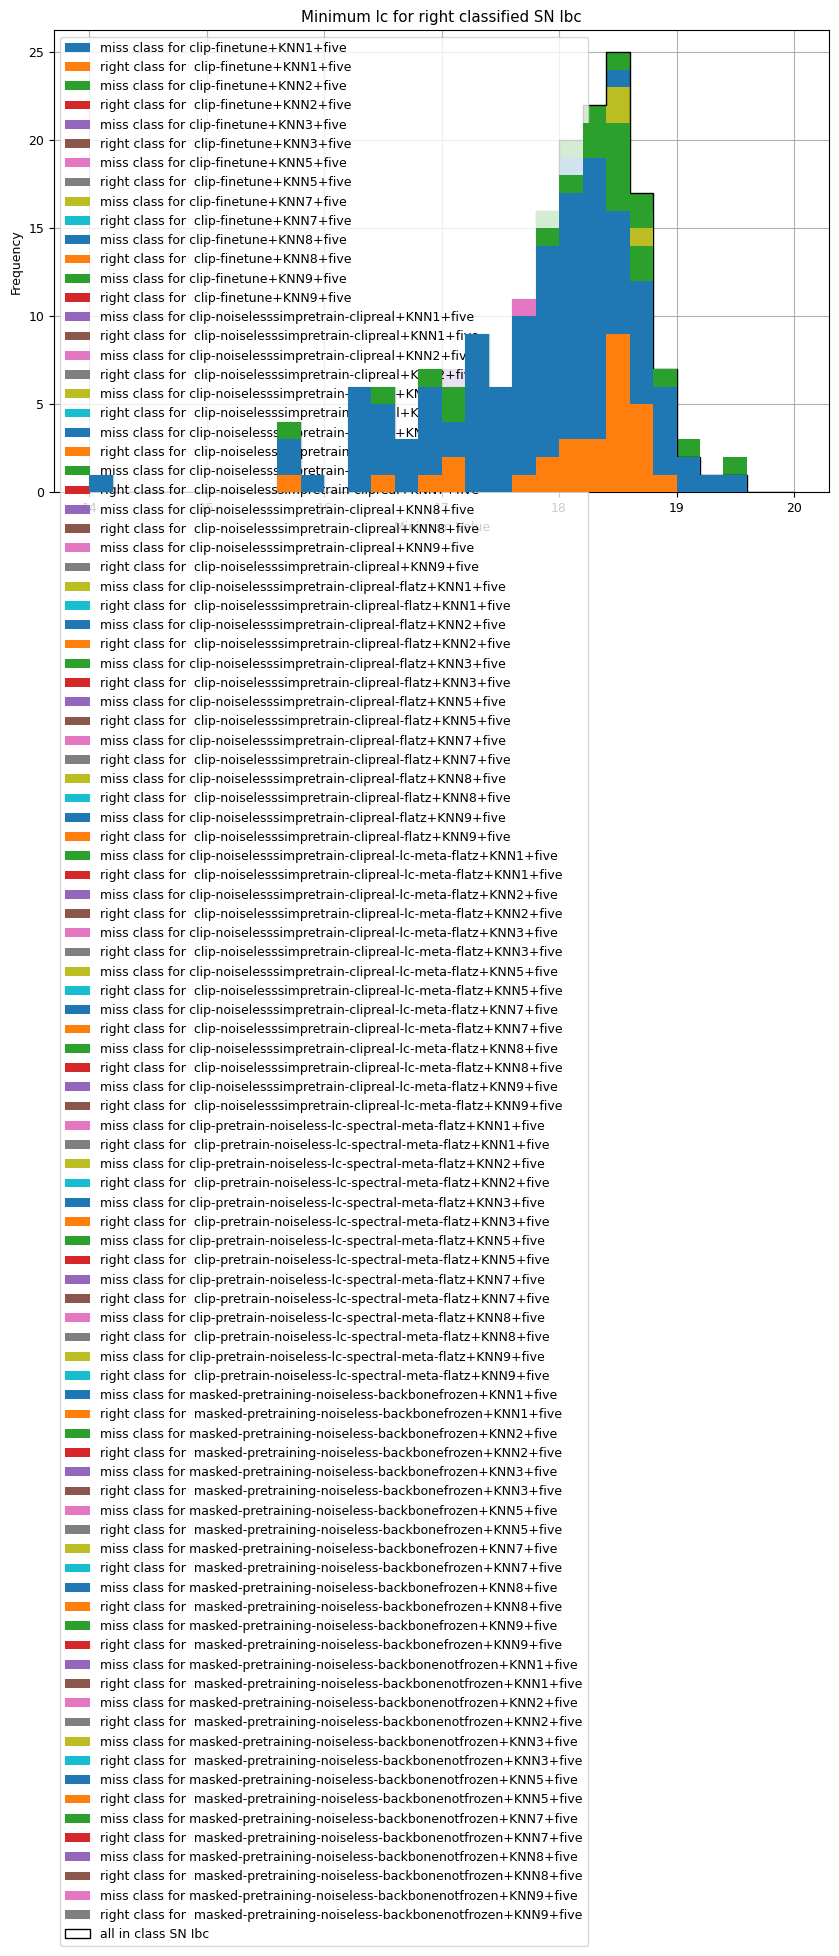

In [26]:
# Plot the masked minimum values
plt.figure(figsize=(10, 6))
for i, (hit, miss) in enumerate(zip(min_lc_data_hit, min_lc_data_miss)):
    if hit is not None:
        plt.hist(
            miss,
            bins=30,
            alpha=1,
            label=f'miss class for {filtered_classified["Model"][i]}',
            range=(14, 20),
            zorder=10 - i,
        )
        plt.hist(
            hit,
            bins=30,
            alpha=1,
            label=f'right class for  {filtered_classified["Model"][i]}',
            range=(14, 20),
            zorder=10 - i,
        )

plt.hist(
    min_lc_data_class_all[0],
    bins=30,
    label=f"all in class {class_names[int(class_filter)][0]}",
    range=(14, 20),
    histtype="step",
    edgecolor="black",
)

plt.title(f"Minimum lc for right classified {class_names[int(class_filter)][0]}")
plt.xlabel("Minimum Value")
plt.ylabel("Frequency")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

### Plot confusion plots

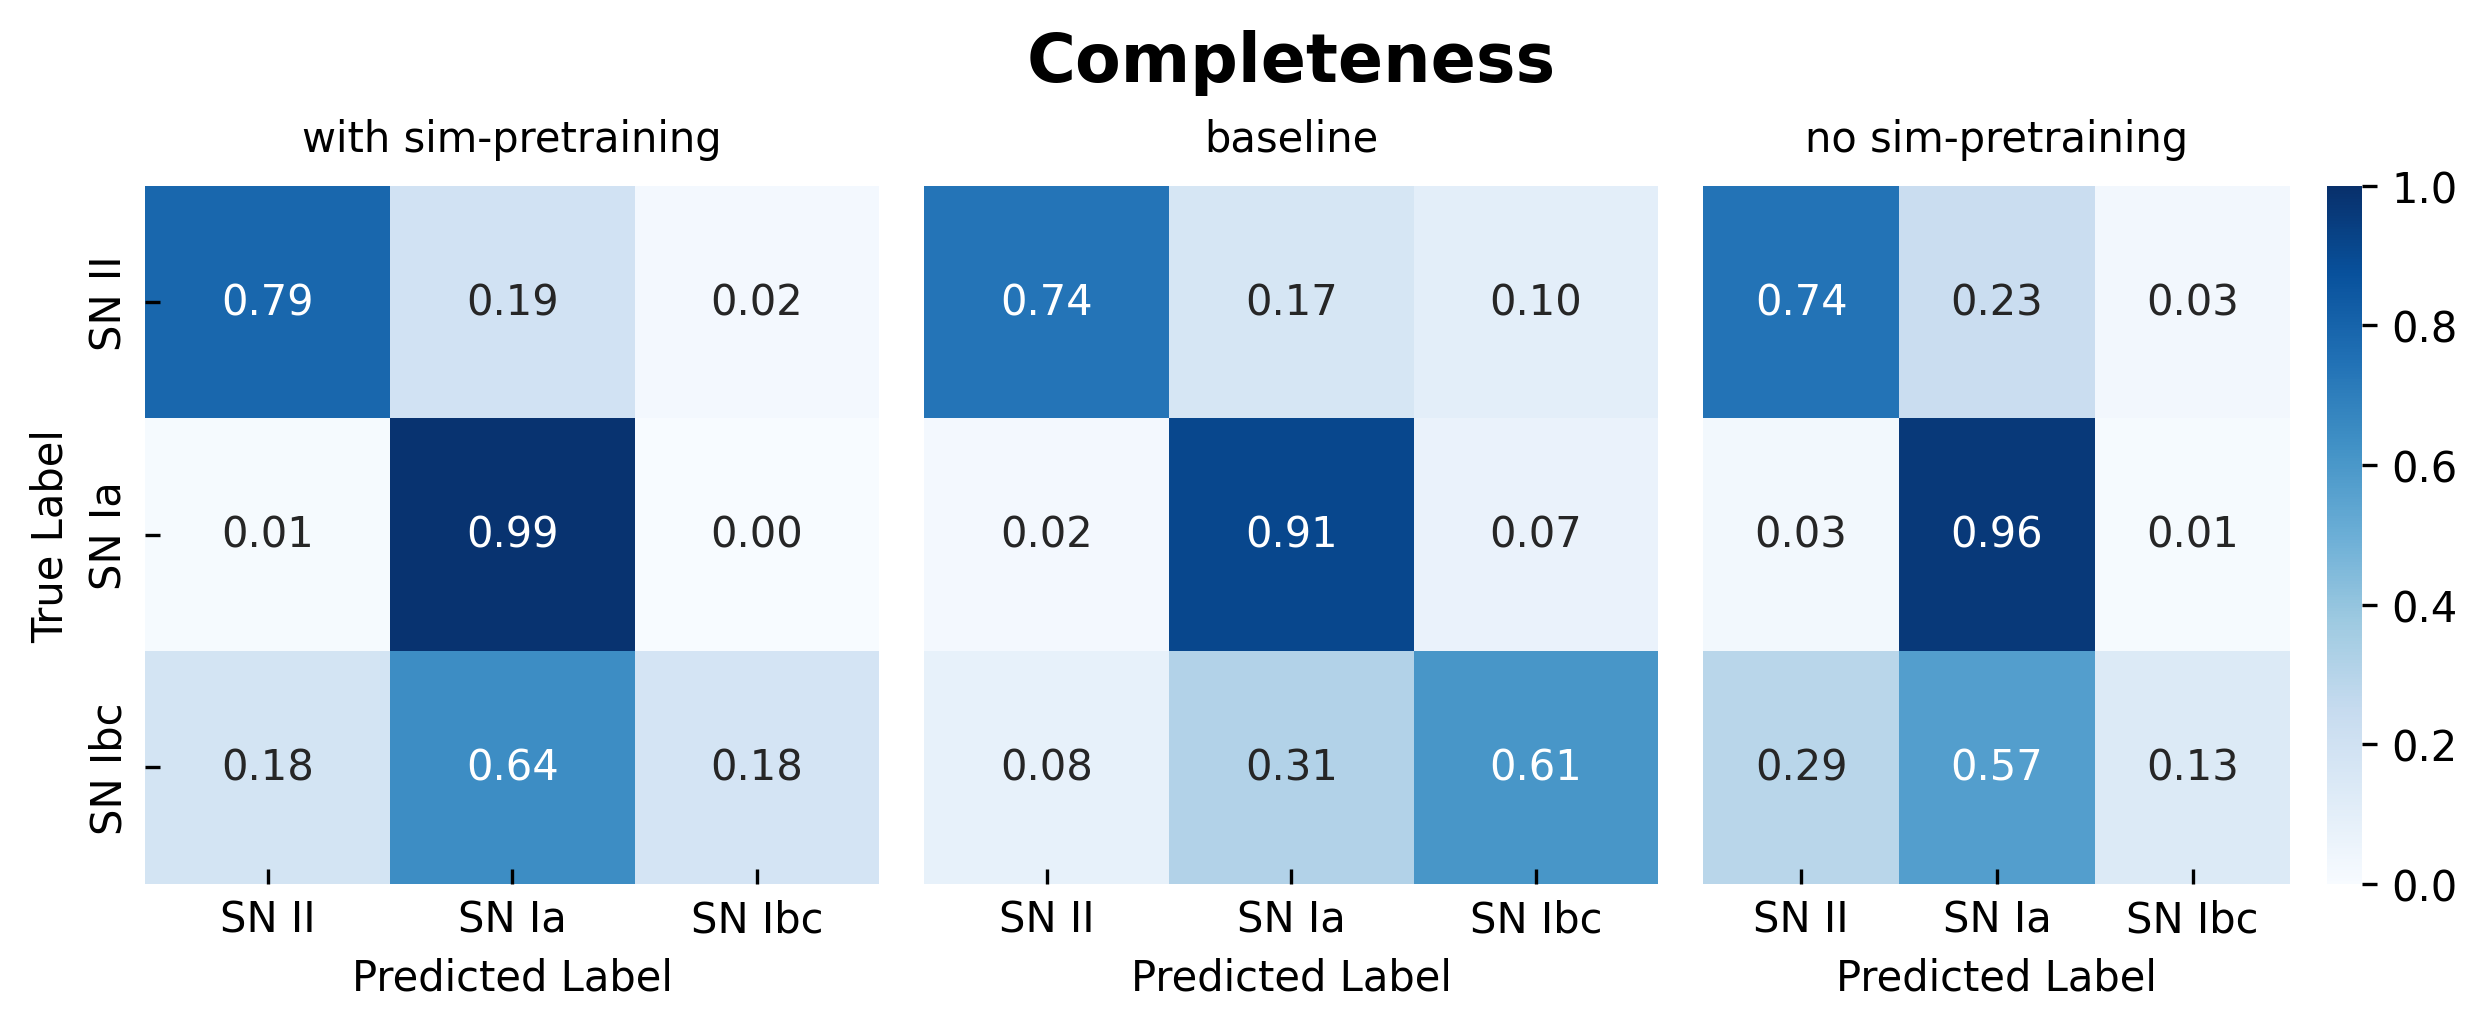

In [37]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns


def plot_cmx3(df_class, modelnames, title, modality, normalisation):
    fig, axes = plt.subplots(1, len(modelnames), figsize=(9.4, 3.6), dpi=300)

    # To ensure the same color scale, we need to determine the max value
    all_cm = []
    for modelname in modelnames:
        df_class_filter = df_class[df_class["Model"] == modelname].reset_index()
        df_class_filter = df_class_filter[
            df_class_filter["Combination"] == modality
        ].reset_index()
        cm = confusion_matrix(
            df_class_filter["y_true_label"][0], df_class_filter["y_pred"][0]
        )
        if normalisation == "recall":
            cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        elif normalisation == "precision":
            cm = cm.astype("float") / cm.sum(axis=0, keepdims=True)
        all_cm.append(cm)

    vmin, vmax = 0, 1 if normalisation in ["recall", "precision"] else None

    for i, modelname in enumerate(modelnames):
        cm = all_cm[i]
        if normalisation == "recall":
            formats = ".2f"
        elif normalisation == "precision":
            formats = ".2f"
        else:
            formats = "d"

        if "five" in modelname or "5way" in modelname:
            class_names = {
                0: ("SLSN-I", "blue"),
                1: ("SN II", "green"),
                2: ("SN IIn", "teal"),
                3: ("SN Ia", "purple"),
                4: ("SN Ibc", "orange"),
            }
        else:
            class_names = {
                0: ("SN II", "green"),
                1: ("SN Ia", "purple"),
                2: ("SN Ibc", "orange"),
            }

        sns.heatmap(
            cm,
            annot=True,
            fmt=formats,
            cmap="Blues",
            xticklabels=[class_names[label][0] for label in sorted(class_names)],
            yticklabels=[class_names[label][0] for label in sorted(class_names)],
            ax=axes[i],
            vmin=vmin,
            vmax=vmax,
            cbar=i == len(modelnames) - 1,  # Only add colorbar to the last plot
            # cbar_ax=None if i else fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Position of the colorbar
        )
        """
        axes[i].set_title(
            f'Normalized Confusion Matrix: {df_class_filter["Model"][0]}, {df_class_filter["Combination"][0]}'
        )
        """
        if i != 1:
            axes[i].set_title("")
            axes[i].text(
                0.5,
                1.05,
                title[i],
                fontsize=10,
                ha="center",
                transform=axes[i].transAxes,
            )
        else:
            if normalisation == "precision":
                axes[i].set_title("")
                axes[i].text(
                    0.5,
                    1.15,
                    "Purity",
                    fontsize=16,
                    fontweight="bold",
                    color="black",
                    ha="center",
                    transform=axes[i].transAxes,
                )
                axes[i].text(
                    0.5,
                    1.05,
                    title[i],
                    fontsize=10,
                    ha="center",
                    transform=axes[i].transAxes,
                )
            elif normalisation == "recall":
                axes[i].set_title("")
                axes[i].text(
                    0.5,
                    1.15,
                    "Completeness",
                    fontsize=16,
                    fontweight="bold",
                    color="black",
                    ha="center",
                    transform=axes[i].transAxes,
                )
                axes[i].text(
                    0.5,
                    1.05,
                    title[i],
                    fontsize=10,
                    ha="center",
                    transform=axes[i].transAxes,
                )
            else:
                axes[i].set_title("")
                axes[i].text(
                    0.5,
                    1.05,
                    title[i],
                    fontsize=10,
                    ha="center",
                    transform=axes[i].transAxes,
                )

        axes[i].set_xlabel("Predicted Label")
        if i == 0:
            axes[i].set_ylabel("True Label")
            axes[i].tick_params(axis="both", direction="in")

        else:
            axes[i].set_yticklabels([])
            axes[i].tick_params(axis="x", direction="in")
            axes[i].set_yticks([])

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(f"cm_{normalisation}.pdf")


# Example usage
title = ["with sim-pretraining", "baseline", "no sim-pretraining"]
modelnames = [
    "clip-noiselesssimpretrain-clipreal+KNN8+three",
    "lc-3way-f1",
    "clip-real+KNN3+three",
]
plot_cmx3(merged_classification, modelnames, title, "lightcurve", "recall")

In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns


def plot_cm(df_class, modelname, modality, normalisation):
    df_class_filter = df_class[df_class["Model"] == modelname].reset_index()
    df_class_filter = df_class_filter[
        df_class_filter["Combination"] == modality
    ].reset_index()

    if "five" in modelname or "5way" in modelname:
        class_names = {
            0: ("SLSN-I", "blue"),
            1: ("SN II", "green"),
            2: ("SN IIn", "teal"),
            3: ("SN Ia", "purple"),
            4: ("SN Ibc", "orange"),
        }
    else:
        class_names = {
            0: ("SN II", "green"),
            1: ("SN Ia", "purple"),
            2: ("SN Ibc", "orange"),
        }

    cm = confusion_matrix(
        df_class_filter["y_true_label"][0], df_class_filter["y_pred"][0]
    )
    if normalisation == "recall":
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        formats = ".2f"
    elif normalisation == "precision":
        cm = cm.astype("float") / cm.sum(axis=0, keepdims=True)
        formats = ".2f"
    else:
        formats = "d"

    # Create the plot
    plt.figure(figsize=(5, 4), dpi=100)
    sns.heatmap(
        cm,
        annot=True,
        fmt=formats,
        cmap="Blues",
        xticklabels=[class_names[label][0] for label in sorted(class_names)],
        yticklabels=[class_names[label][0] for label in sorted(class_names)],
    )
    plt.title(
        f'Normalized Confusion Matrix: {df_class_filter["Model"][0]}, {df_class_filter["Combination"][0]}'
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

In [29]:
print(f'available models: \n {merged_classification["Model"]}')

available models: 
 0                                clip-finetune+KNN1+five
1                                clip-finetune+KNN1+five
2                                clip-finetune+KNN1+five
3                               clip-finetune+KNN1+three
4                               clip-finetune+KNN1+three
                             ...                        
775    masked-pretraining-noiseless-backbonenotfrozen...
776    masked-pretraining-noiseless-backbonenotfrozen...
777    masked-pretraining-noiseless-backbonenotfrozen...
778                                           sp-3way-f1
779                                           sp-5way-f1
Name: Model, Length: 780, dtype: object


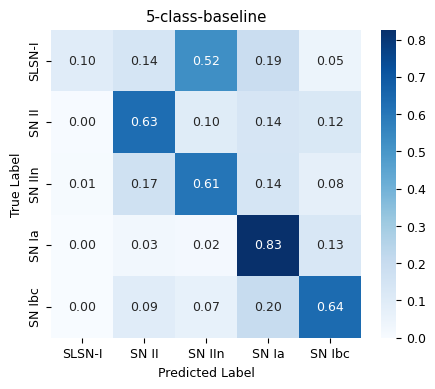

In [30]:
modelname = "lc-5way-f1"
plot_cm(
    merged_classification,
    modelname="lc-5way-f1",
    modality="lightcurve",
    normalisation="recall",  # "recall" / "precision"
)
plt.title("5-class-baseline")
plt.savefig(f"cm_{modelname}.png")

# Classbased analysis of regression results

In [31]:
def get_class_regression_metric(df):
    df = pd.DataFrame(df)
    class_dependent_regression_metrics = []
    # Iterate over each row in the DataFrame to create plots
    for index, row in df.iterrows():
        y_pred = torch.Tensor(row["y_pred"])
        y_true = torch.Tensor(row["y_true"])
        y_true_label = torch.Tensor(row["y_true_label"])
        label = row["Model"]
        combs = row["Combination"]
        id = row["id"]
        task = "regression"

        # Determine global axis limits
        x_min, x_max = y_true.min(), y_true.max()
        y_min, y_max = y_pred.min(), y_pred.max()

        x_min = min(0, x_min)
        y_min = min(0, y_min)

        # Setup for subplots
        unique_labels = np.unique(y_true_label)
        for i, classid in enumerate(unique_labels, 1):

            # Highlight the current class
            idx = y_true_label == classid

            metrics, results = calculate_metrics(
                y_true[idx],
                y_true_label[idx],
                y_pred[idx],
                None,
                label + "+" + class_names[classid][0],
                combs,
                id=id,
                task=task,
            )
            class_dependent_regression_metrics.append(metrics)
    return class_dependent_regression_metrics


class_dependent_regression_metrics = get_class_regression_metric(
    collect_regression_results
)
class_dependent_regression_metrics_all = get_class_regression_metric(merged_regression)

In [32]:
regress_class_dependet_mean, regress_class_dependet_std = calculate_kfold_mean_and_std(
    class_dependent_regression_metrics
)

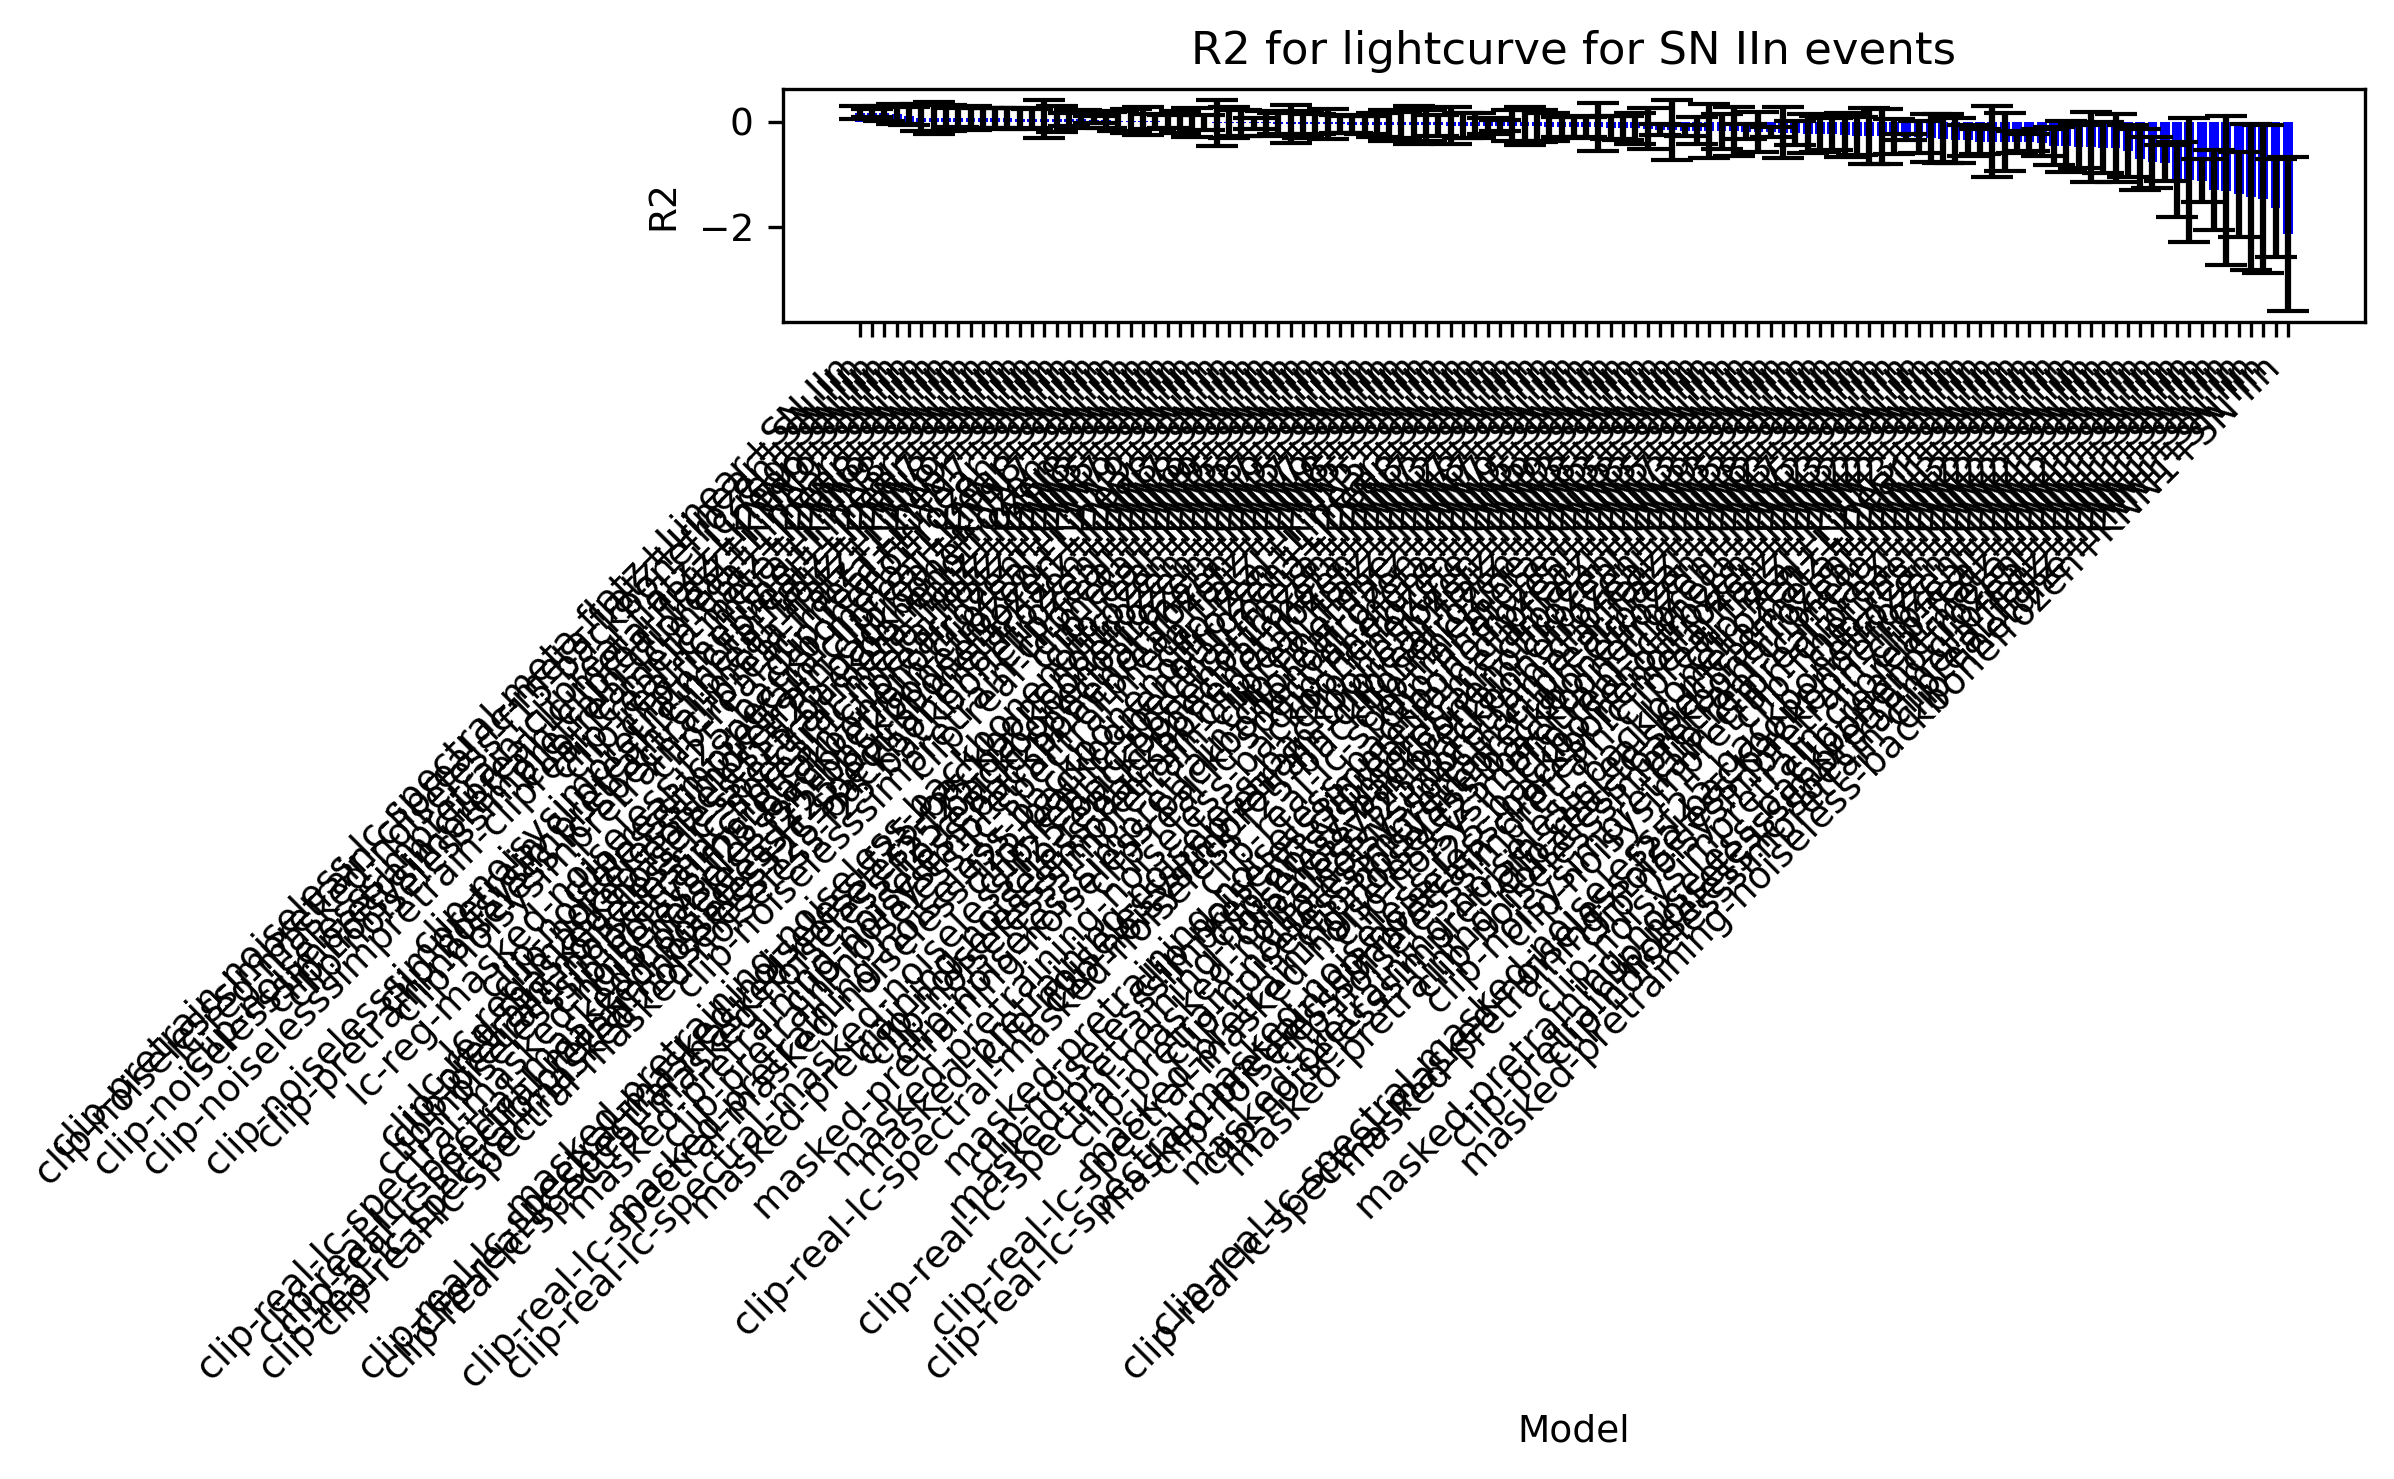

In [33]:
supernovae_type = "SN IIn"  # ['SLSN-I', 'SN II', 'SN IIn', 'SN Ia', 'SN Ibc']
modality = "lightcurve"
variable_name = "R2"

mean_data_filtered = regress_class_dependet_mean[
    regress_class_dependet_mean["Combination"] == modality
].reset_index()
std_data_filtered = regress_class_dependet_std[
    regress_class_dependet_std["Combination"] == modality
].reset_index()

std_data_filtered["supernova_type"] = [
    entry.split("+")[-1] for entry in std_data_filtered["Model"]
]
mean_data_filtered["supernova_type"] = [
    entry.split("+")[-1] for entry in mean_data_filtered["Model"]
]
# Extract data for lightcurve combination

mean_data_filteredSNtype = mean_data_filtered[
    mean_data_filtered["supernova_type"] == supernovae_type
].reset_index()
std_data_filteredSNtype = std_data_filtered[
    std_data_filtered["supernova_type"] == supernovae_type
].reset_index()

mean_data_filteredSNtype = mean_data_filteredSNtype.sort_values(
    by=variable_name, ascending=False
)
std_data_filteredSNtype = std_data_filteredSNtype.loc[mean_data_filteredSNtype.index]

plt.figure(figsize=(8, 5), dpi=300)
plt.bar(
    mean_data_filteredSNtype["Model"],
    mean_data_filteredSNtype[variable_name],
    yerr=std_data_filteredSNtype[variable_name],
    capsize=5,
    color="blue",
)
plt.xlabel("Model")
plt.ylabel(variable_name)
plt.title(f"{variable_name} for lightcurve for {supernovae_type} events")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

In [39]:
import os


def plot_all_pred_vs_true(df, class_names):
    """
    Creates and saves a plot for each row in the DataFrame, where each subplot within a plot
    corresponds to a unique class. Each class is plotted with its designated color and label.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing the data for plots. Expected to have columns:
      'y_pred', 'y_true', 'y_true_label', 'Model', and 'Combination'.
    - folder_name (str): Directory name where the plots will be saved.
    - class_names (dict): Dictionary mapping class labels (int) to tuples of (class name, color).

    Each plot is saved with the filename format "Model_Combination.png", where spaces are removed.
    """

    # Iterate over each row in the DataFrame to create plots
    plt.figure(figsize=(15, 30))
    ymins = []
    ymaxs = []
    xmins = []
    xmaxs = []

    for index, row in df.iterrows():
        y_pred = np.array(row["y_pred"])
        y_true = np.array(row["y_true"])
        y_true_label = np.array(row["y_true_label"])
        model = row["Model"]

        # Determine global axis limits
        x_min, x_max = y_true.min(), y_true.max()
        y_min, y_max = y_pred.min(), y_pred.max()

        x_min = min(0, x_min)
        y_min = min(0, y_min)
        ymins.append(y_min)
        ymaxs.append(y_max)
        xmins.append(x_min)
        xmaxs.append(x_max)

        # Setup for subplots
        unique_labels = np.unique(y_true_label)
        n_classes = len(class_names)
        red_line = np.linspace(-1, 1, 100)
        for i, label in enumerate(range(n_classes), 1):
            ax = plt.subplot(n_classes, 1, i)

            # Highlight the current class
            idx = y_true_label == label
            class_color = class_names[label][1]  # Color corresponding to the label
            if model != "lc-reg":
                ax.scatter(
                    y_true[idx],
                    y_pred[idx],
                    # color=class_color,
                    label=f"{model}",
                )
            else:
                ax.scatter(
                    y_true[idx],
                    y_pred[idx],
                    # color=class_color,
                    label=f"{model}",
                    alpha=0.5,
                    c="gray",
                )

            ax.plot(
                red_line, red_line, linewidth=3, alpha=0.4, linestyle="--", color="red"
            )

            # Set tick parameters
            ax.xaxis.set_major_locator(
                ticker.MultipleLocator(0.05)
            )  # Adjust tick spacing as needed
            ax.yaxis.set_major_locator(
                ticker.MultipleLocator(0.05)
            )  # Adjust tick spacing as needed
            ax.tick_params(direction="in", length=6, width=2)

            ax.set_title(f"{class_names[label][0]}")
            ax.set_xlabel("True Redshift")
            ax.set_ylabel("Predicted Redshift")
            ax.set_xlim(min(xmins), max(xmaxs))
            ax.set_ylim(min(ymins), max(ymaxs))
            ax.legend()
            ax.grid(True)

In [40]:
remove_models = ["five", "5way", "Linear", "nois", "clip-real", "spectral"]
"""
remove_models = [
    "three",
    "3way",
    "Linear",
]  
"""
merged_regression = pd.DataFrame(merged_regression)
lc_merged_regression = merged_regression[
    merged_regression["Combination"] == "lightcurve"
]

# Create a regex pattern from the list of strings
pattern = "|".join(remove_models)

if "three" in remove_models:
    class_names = {
        0: ("SLSN-I", "blue"),
        1: ("SN II", "green"),
        2: ("SN IIn", "teal"),
        3: ("SN Ia", "purple"),
        4: ("SN Ibc", "orange"),
    }
else:
    class_names = {
        0: ("SN II", "green"),
        1: ("SN Ia", "purple"),
        2: ("SN Ibc", "orange"),
    }

# Remove rows where the 'Model' column contains any of the strings in remove_models
df_cleaned = lc_merged_regression[
    ~lc_merged_regression["Model"].str.contains(pattern)
].reset_index()
print("We will work with these models: ")
print(df_cleaned[["Model", "Combination"]])

We will work with these models: 
                Model Combination
0  clip-finetune+KNN1  lightcurve
1  clip-finetune+KNN2  lightcurve
2  clip-finetune+KNN3  lightcurve
3  clip-finetune+KNN5  lightcurve
4  clip-finetune+KNN7  lightcurve
5  clip-finetune+KNN8  lightcurve
6  clip-finetune+KNN9  lightcurve
7              lc-reg  lightcurve


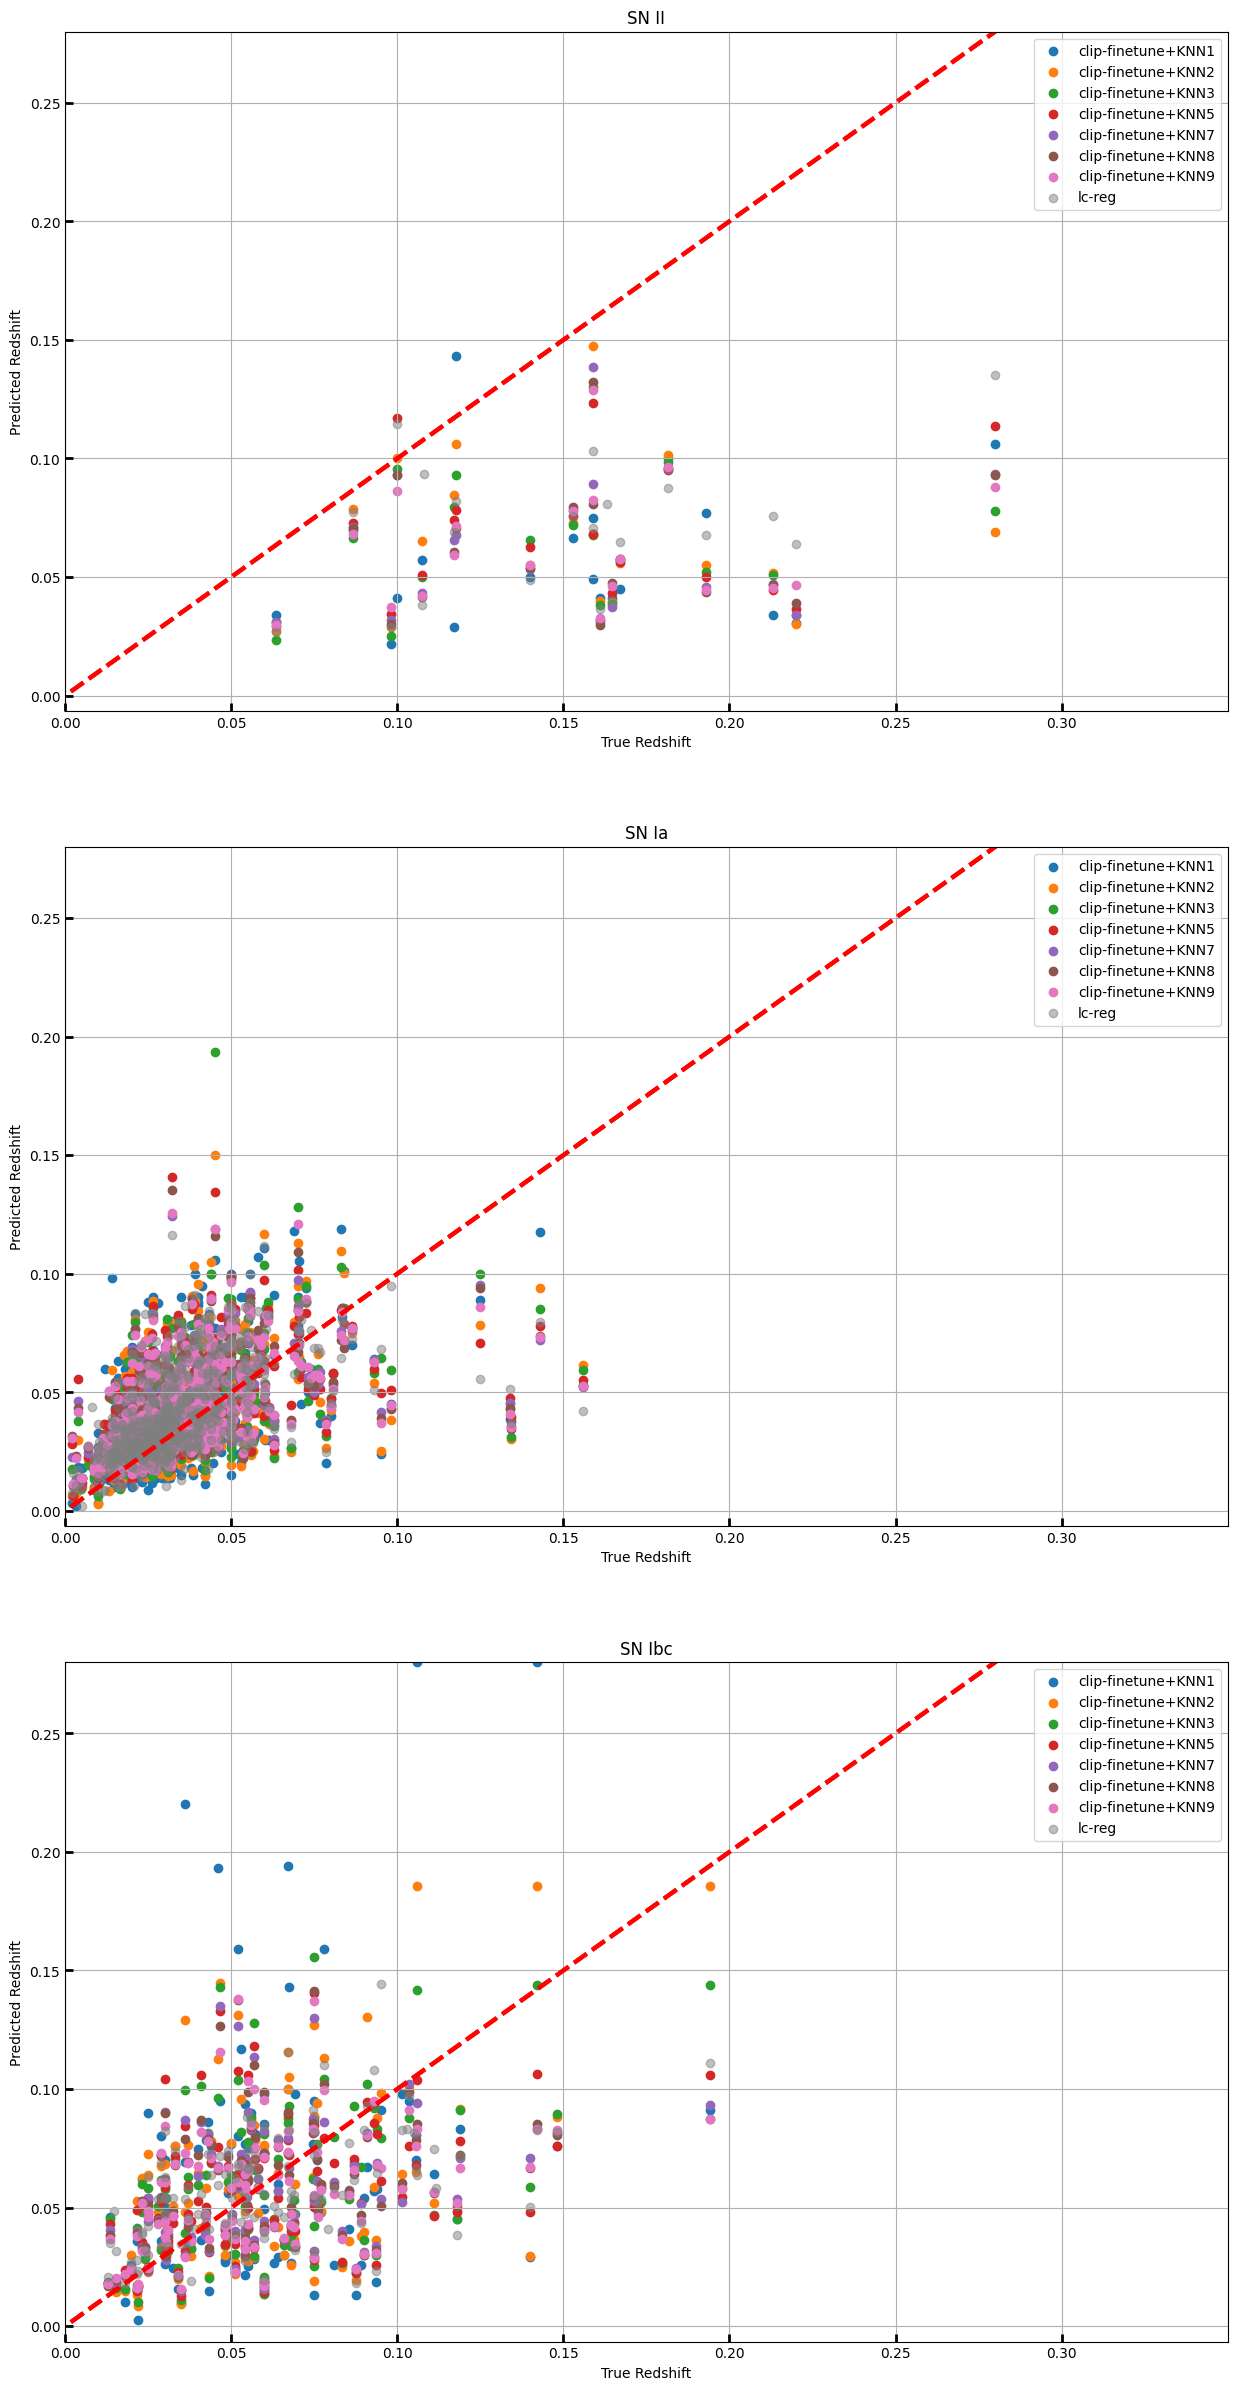

In [41]:
plot_all_pred_vs_true(df_cleaned, class_names)
plt.savefig("meh.png")

In [42]:
lc_merged_regression[lc_merged_regression["Model"] == "lc-reg"]

Model Combination  id  \
336  lc-reg  lightcurve  22   

                                                y_pred  \
336  [0.028768044, 0.03403655, 0.06456649, 0.011049...   

                                                y_true  \
336  [0.098, 0.02805, 0.06021, 0.0034, 0.0246, 0.03...   

                                          y_true_label  \
336  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                               lc_data  
336  {'x_lc': [[17.887798, 17.62559, 17.518978, 17....

In [43]:
lc_merged_regression["Model"].values

array(['clip-finetune+KNN1', 'clip-finetune+KNN2', 'clip-finetune+KNN3',
       'clip-finetune+KNN5', 'clip-finetune+KNN7', 'clip-finetune+KNN8',
       'clip-finetune+KNN9', 'clip-finetune+Linear',
       'clip-noiselesssimpretrain-clipreal+KNN1',
       'clip-noiselesssimpretrain-clipreal+KNN2',
       'clip-noiselesssimpretrain-clipreal+KNN3',
       'clip-noiselesssimpretrain-clipreal+KNN5',
       'clip-noiselesssimpretrain-clipreal+KNN7',
       'clip-noiselesssimpretrain-clipreal+KNN8',
       'clip-noiselesssimpretrain-clipreal+KNN9',
       'clip-noiselesssimpretrain-clipreal+Linear',
       'clip-noiselesssimpretrain-clipreal-flatz+KNN1',
       'clip-noiselesssimpretrain-clipreal-flatz+KNN2',
       'clip-noiselesssimpretrain-clipreal-flatz+KNN3',
       'clip-noiselesssimpretrain-clipreal-flatz+KNN5',
       'clip-noiselesssimpretrain-clipreal-flatz+KNN7',
       'clip-noiselesssimpretrain-clipreal-flatz+KNN8',
       'clip-noiselesssimpretrain-clipreal-flatz+KNN9',
       

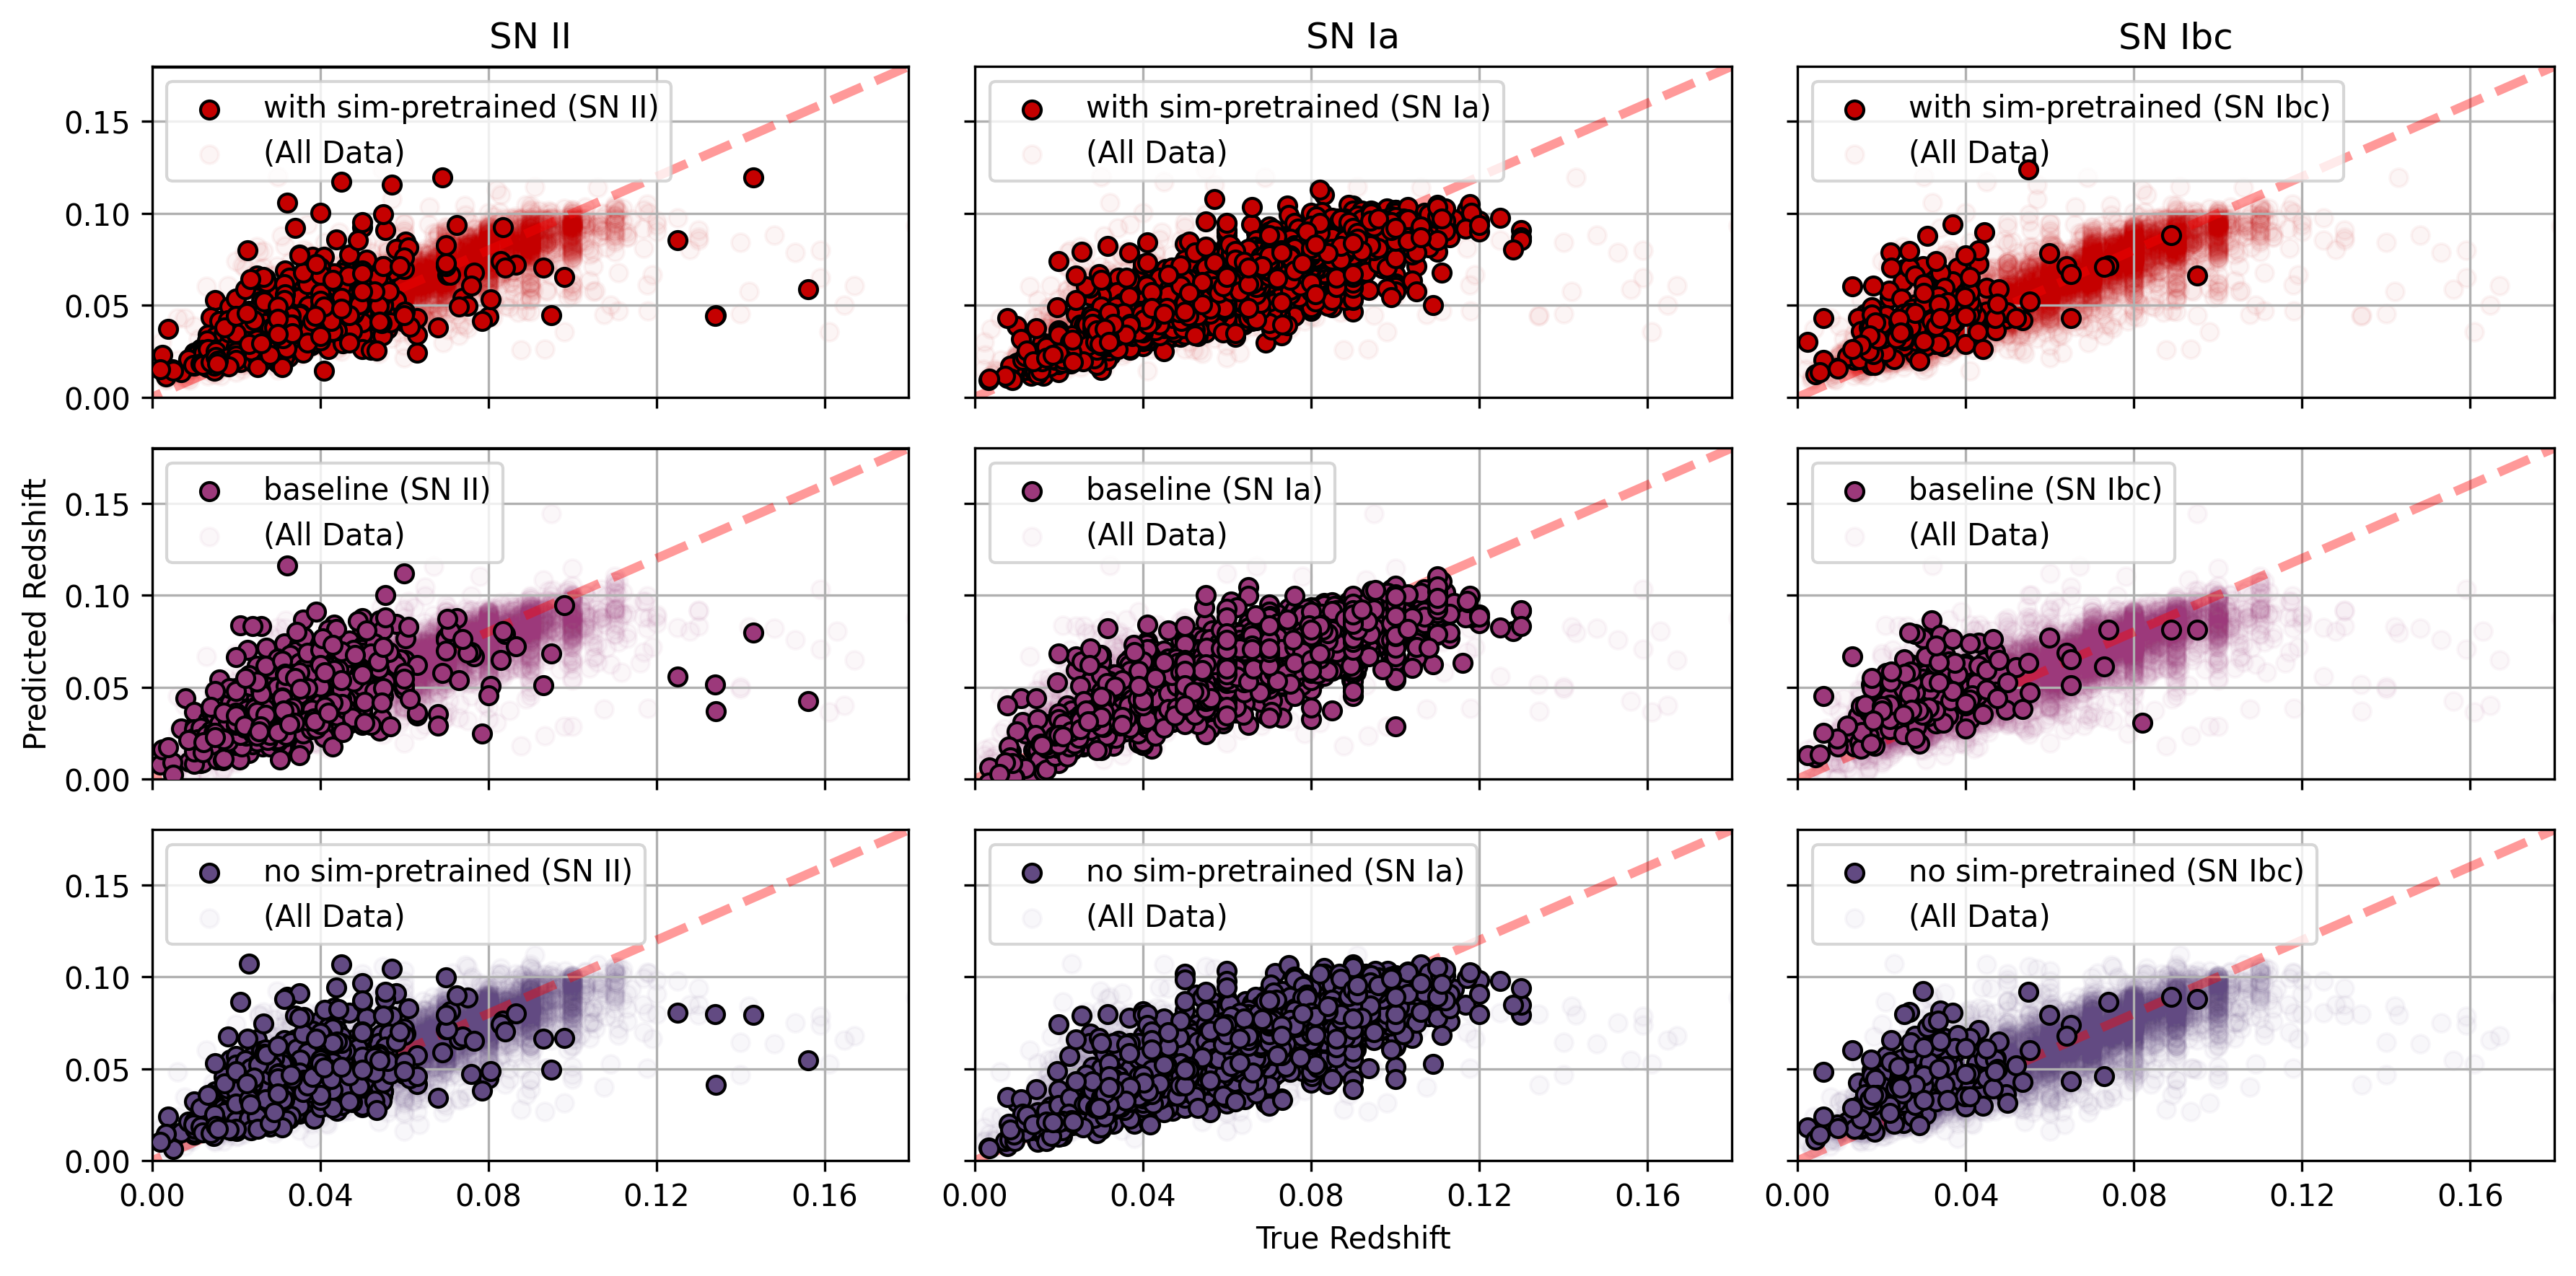

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def plot_pred_vs_true_for_supernova(
    df, class_names, models, colors, names, supernova_subset
):
    """
    Plots y_pred vs y_true for specified supernova types across multiple models in separate subplots.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing the data for plots. Expected to have columns:
      'y_pred', 'y_true', 'y_true_label', 'Model', and 'Combination'.
    - class_names (dict): Dictionary mapping class labels (int) to tuples of (class name, color).
    - models (list): List of models to include in the plot.
    - colors (list): List of colors to use for the different models.
    - names (list): List of names for the models.
    - supernova_subset (list): List of supernova names to include in the plot.
    """

    # Find the class labels corresponding to the given supernova names
    class_labels = {
        label: (name, color)
        for label, (name, color) in class_names.items()
        if name in supernova_subset
    }

    if not class_labels:
        print(f"No supernova classes found in the subset: {supernova_subset}")
        return

    n_models = len(models)
    n_classes = len(class_labels)
    fig, axes = plt.subplots(
        n_models,
        n_classes,
        figsize=(4 * n_classes, 2.0 * n_models),
        sharex=True,
        sharey=True,
        dpi=300,
    )

    xmax = 0.05
    xmin = 0
    ymax = 0.05
    ymin = 0

    # Iterate over the specified models and plot the data for the given supernova classes
    for k, model in enumerate(models):
        for j, (class_label, (class_name, class_color)) in enumerate(
            class_labels.items()
        ):
            ax = (
                axes[k, j]
                if n_models > 1 and n_classes > 1
                else (axes[j] if n_models == 1 else axes[k])
            )
            df_model = df[df["Model"] == model]
            y_pred = np.concatenate(df_model["y_pred"].values)
            y_true = np.concatenate(df_model["y_true"].values)
            y_true_label = np.concatenate(df_model["y_true_label"].values)
            xmax = max(xmax, max(y_true))
            ymax = max(ymax, max(y_pred))
            idx = y_true_label == class_label
            ax.scatter(
                y_true[idx],
                y_pred[idx],
                color=colors[k],
                edgecolor="black",
                label=f"{names[k]} ({class_name})",
                zorder=99,
            )
            ax.scatter(y_true, y_pred, alpha=0.04, color=colors[k], label=f"(All Data)")

            red_line = np.linspace(-1, 1, 100)
            ax.plot(
                red_line, red_line, linewidth=3, alpha=0.4, linestyle="--", color="red"
            )
            ax.set_xlim((xmin, 0.18))
            ax.set_ylim((ymin, 0.18))
            ax.set_xticks(np.arange(xmin, 0.18, 0.04))
            ax.set_yticks(np.arange(ymin, 0.18, 0.05))

            if k == n_models - 1 and j == n_models // 2:
                ax.set_xlabel("True Redshift")
            if j == 0 and k == n_classes // 2:
                ax.set_ylabel("Predicted Redshift")
            if k == 0:
                ax.set_title(f"{class_name}")
            ax.legend()
            ax.grid(True)

    # Align x-axes and remove redundant axes
    for ax in axes.flat:
        ax.label_outer()

    for k in range(n_models - 1):
        axes[k, 0].axhline(y=0.18, color="black", linewidth=1.5)

    plt.tight_layout()


# Example usage
models_to_plot = [
    "clip-noiselesssimpretrain-clipreal+KNN9",
    "lc-reg",
    "clip-real+KNN9",
]  # Replace with actual model names
supernova_subset = ["SN Ia", "SN II", "SN Ibc"]  # List of supernova names to include
class_names = {
    0: ("SLSN-I", "blue"),
    1: ("SN II", "green"),
    2: ("SN IIn", "teal"),
    3: ("SN Ia", "purple"),
    4: ("SN Ibc", "orange"),
}
colors = ["#c50000", "#9c397b", "#624a82"]
names = ["with sim-pretrained", "baseline", "no sim-pretrained"]

plot_pred_vs_true_for_supernova(
    lc_merged_regression, class_names, models_to_plot, colors, names, supernova_subset
)
plt.savefig("true-vs-pred.pdf")
plt.savefig("true-vs-pred.png")

In [45]:
lc_merged_regression[lc_merged_regression["Model"] == "lc_reg"]

Empty DataFrame
Columns: [Model, Combination, id, y_pred, y_true, y_true_label, lc_data]
Index: []

### Example sc/lc plot

In [46]:
from src.dataloader import (
    load_data,
    NoisyDataLoader,
)
from src.utils import (
    get_valid_dir,
)

In [47]:
data_dirs = [
    "/home/thelfer1/scr4_tedwar42/thelfer1/ZTFBTS/",
    "ZTFBTS/",
    "data/ZTFBTS/",
    "/ocean/projects/phy230064p/shared/ZTFBTS/",
    "/n/home02/gemzhang/repos/Multimodal-hackathon-2024/data/ZTFBTS/",
]

# Get the first valid directory
data_dir = get_valid_dir(data_dirs)

# Check if the config file has a spectra key
data_dirs = ["ZTFBTS_spectra/", "data/ZTFBTS_spectra/"]
spectra_dir = get_valid_dir(data_dirs)

In [43]:
dataset, nband, filenames, stratifiedkfoldindices = load_data(
    data_dir,
    spectra_dir,
    max_data_len_spec=1000,
    combinations=["lightcurve", "spectral"],
    n_classes=5,
    spectral_rescalefactor=1,
    kfolds=5,
)

Loading light curves...


100%|██████████████████████████████████████| 5170/5170 [00:41<00:00, 124.08it/s]


Loading spectra ...


100%|██████████████████████████████████████| 5020/5020 [00:17<00:00, 287.15it/s]


Loading redshifts...
Finished loading redshift
Loading transient classes...
Finished loading transient classes.


/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/ipykernel_18642/121213996.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')


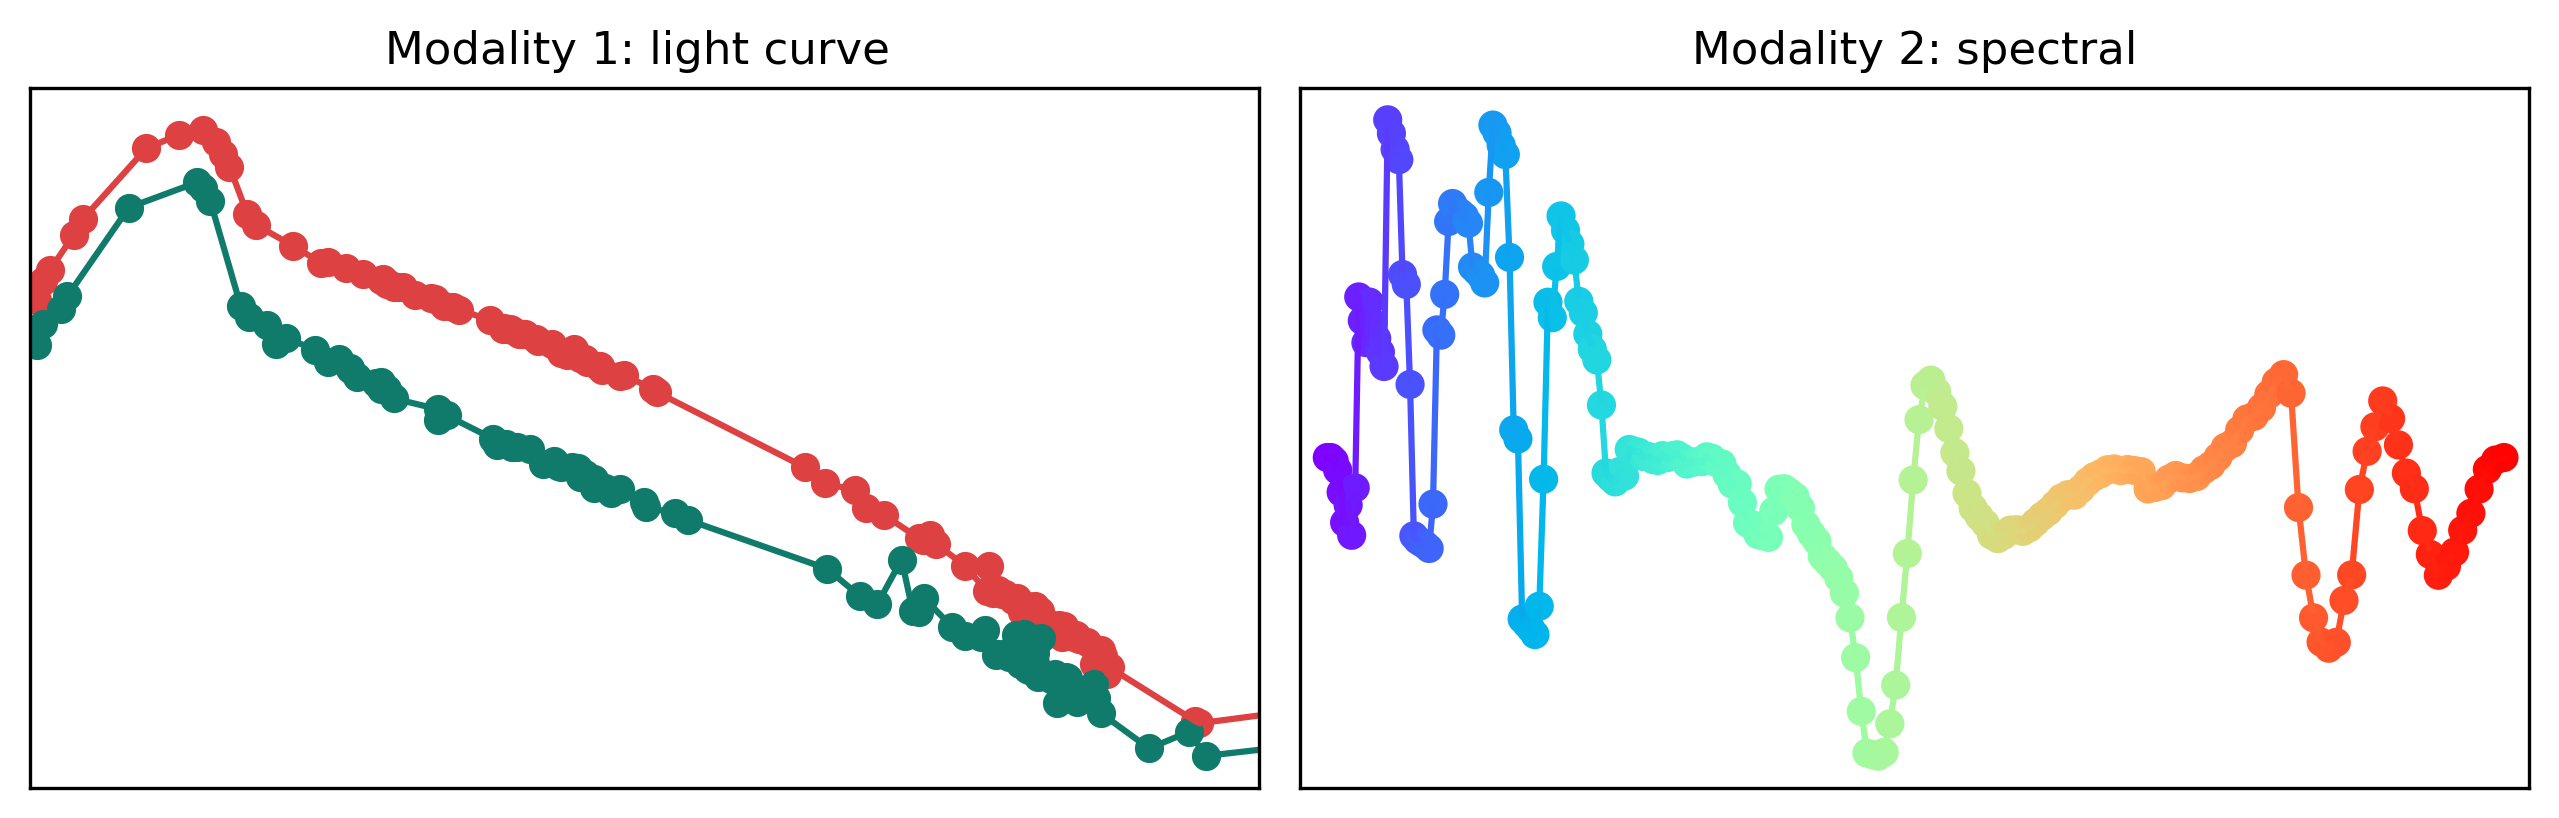

In [44]:
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

for batch in dataset:
    mag, time, mask, magerr, spec, freq, maskspec, specerr, redshift, classification = (
        batch
    )
    if sum(mask) == 200:
        fig, axes = plt.subplots(1, 2, figsize=(8.6, 2.8), dpi=300)
        idx_sort = np.argsort(time[:100][mask[:100]])
        Rbandtime = time[:100][mask[:100]][idx_sort]
        Rbandmag = mag[:100][mask[:100]][idx_sort]
        idx_sort = np.argsort(time[100:][mask[100:]])
        gbandtime = time[100:][mask[100:]][idx_sort]
        axes[0].set_title("Modality 1: light curve ")
        axes[1].set_title("Modality 2: spectral")
        gbandmag = mag[100:][mask[100:]][idx_sort]
        axes[0].plot(Rbandtime, Rbandmag, label="R band", color="#de4141")
        axes[0].scatter(Rbandtime, Rbandmag, color="#de4141")
        axes[0].plot(gbandtime, gbandmag, label="g band", color="#107b6a")
        axes[0].scatter(gbandtime, gbandmag, color="#107b6a")
        axes[0].set_xlim([0, 560])
        sort_idx = np.argsort(freq[maskspec])
        freqs = freq[maskspec][sort_idx]
        specs = spec[maskspec][sort_idx]
        # Normalize the data positions
        norm = plt.Normalize(vmin=0, vmax=len(freqs))
        # Create a colormap
        cmap = cm.get_cmap("rainbow")
        # Assign colors to the data points
        colors = cmap(norm(range(len(freqs))))
        # axes[1].plot(freqs,specs,label = 'spectral',color=colors)
        axes[1].scatter(freqs, specs, label="spectral", c=colors)
        for i in range(len(freqs) - 1):
            axes[1].plot(freqs[i : i + 2], specs[i : i + 2], color=colors[i])
        # Create a custom legend symbol
        rainbow_line = Line2D(
            [0],
            [0],
            color="white",
            marker="o",
            markersize=0,
            linestyle="-",
            lw=2,
            markerfacecolor="none",
            markeredgecolor="none",
        )
        axes[1].set_xlim([3650, 9300])
        axes[0].set_ylim([21, 13.5])

        # Add the custom legend
        """
        axes[0].legend(loc = 'upper right',frameon=False)
        axes[1].legend([rainbow_line], ['Spectral'],frameon=False,loc = 'upper right')
        axes[1].set_xlabel('Wavelength (Angstroms)')
        axes[1].set_ylabel('Normalized Flux + offset')
        axes[0].set_xlabel('Time since first detection (Days)')
        axes[0].set_ylabel('Apparent magnitude')
        """
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        axes[1].set_xticks([])
        axes[1].set_yticks([])

        plt.tight_layout()
        plt.savefig("example_data.pdf")
        break

### Conceptual plot 

/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/ipykernel_18642/1912520869.py:92: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.pane.fill = False
/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/ipykernel_18642/1912520869.py:93: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.pane.fill = False
/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/ipykernel_18642/1912520869.py:94: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.pane.fill = False


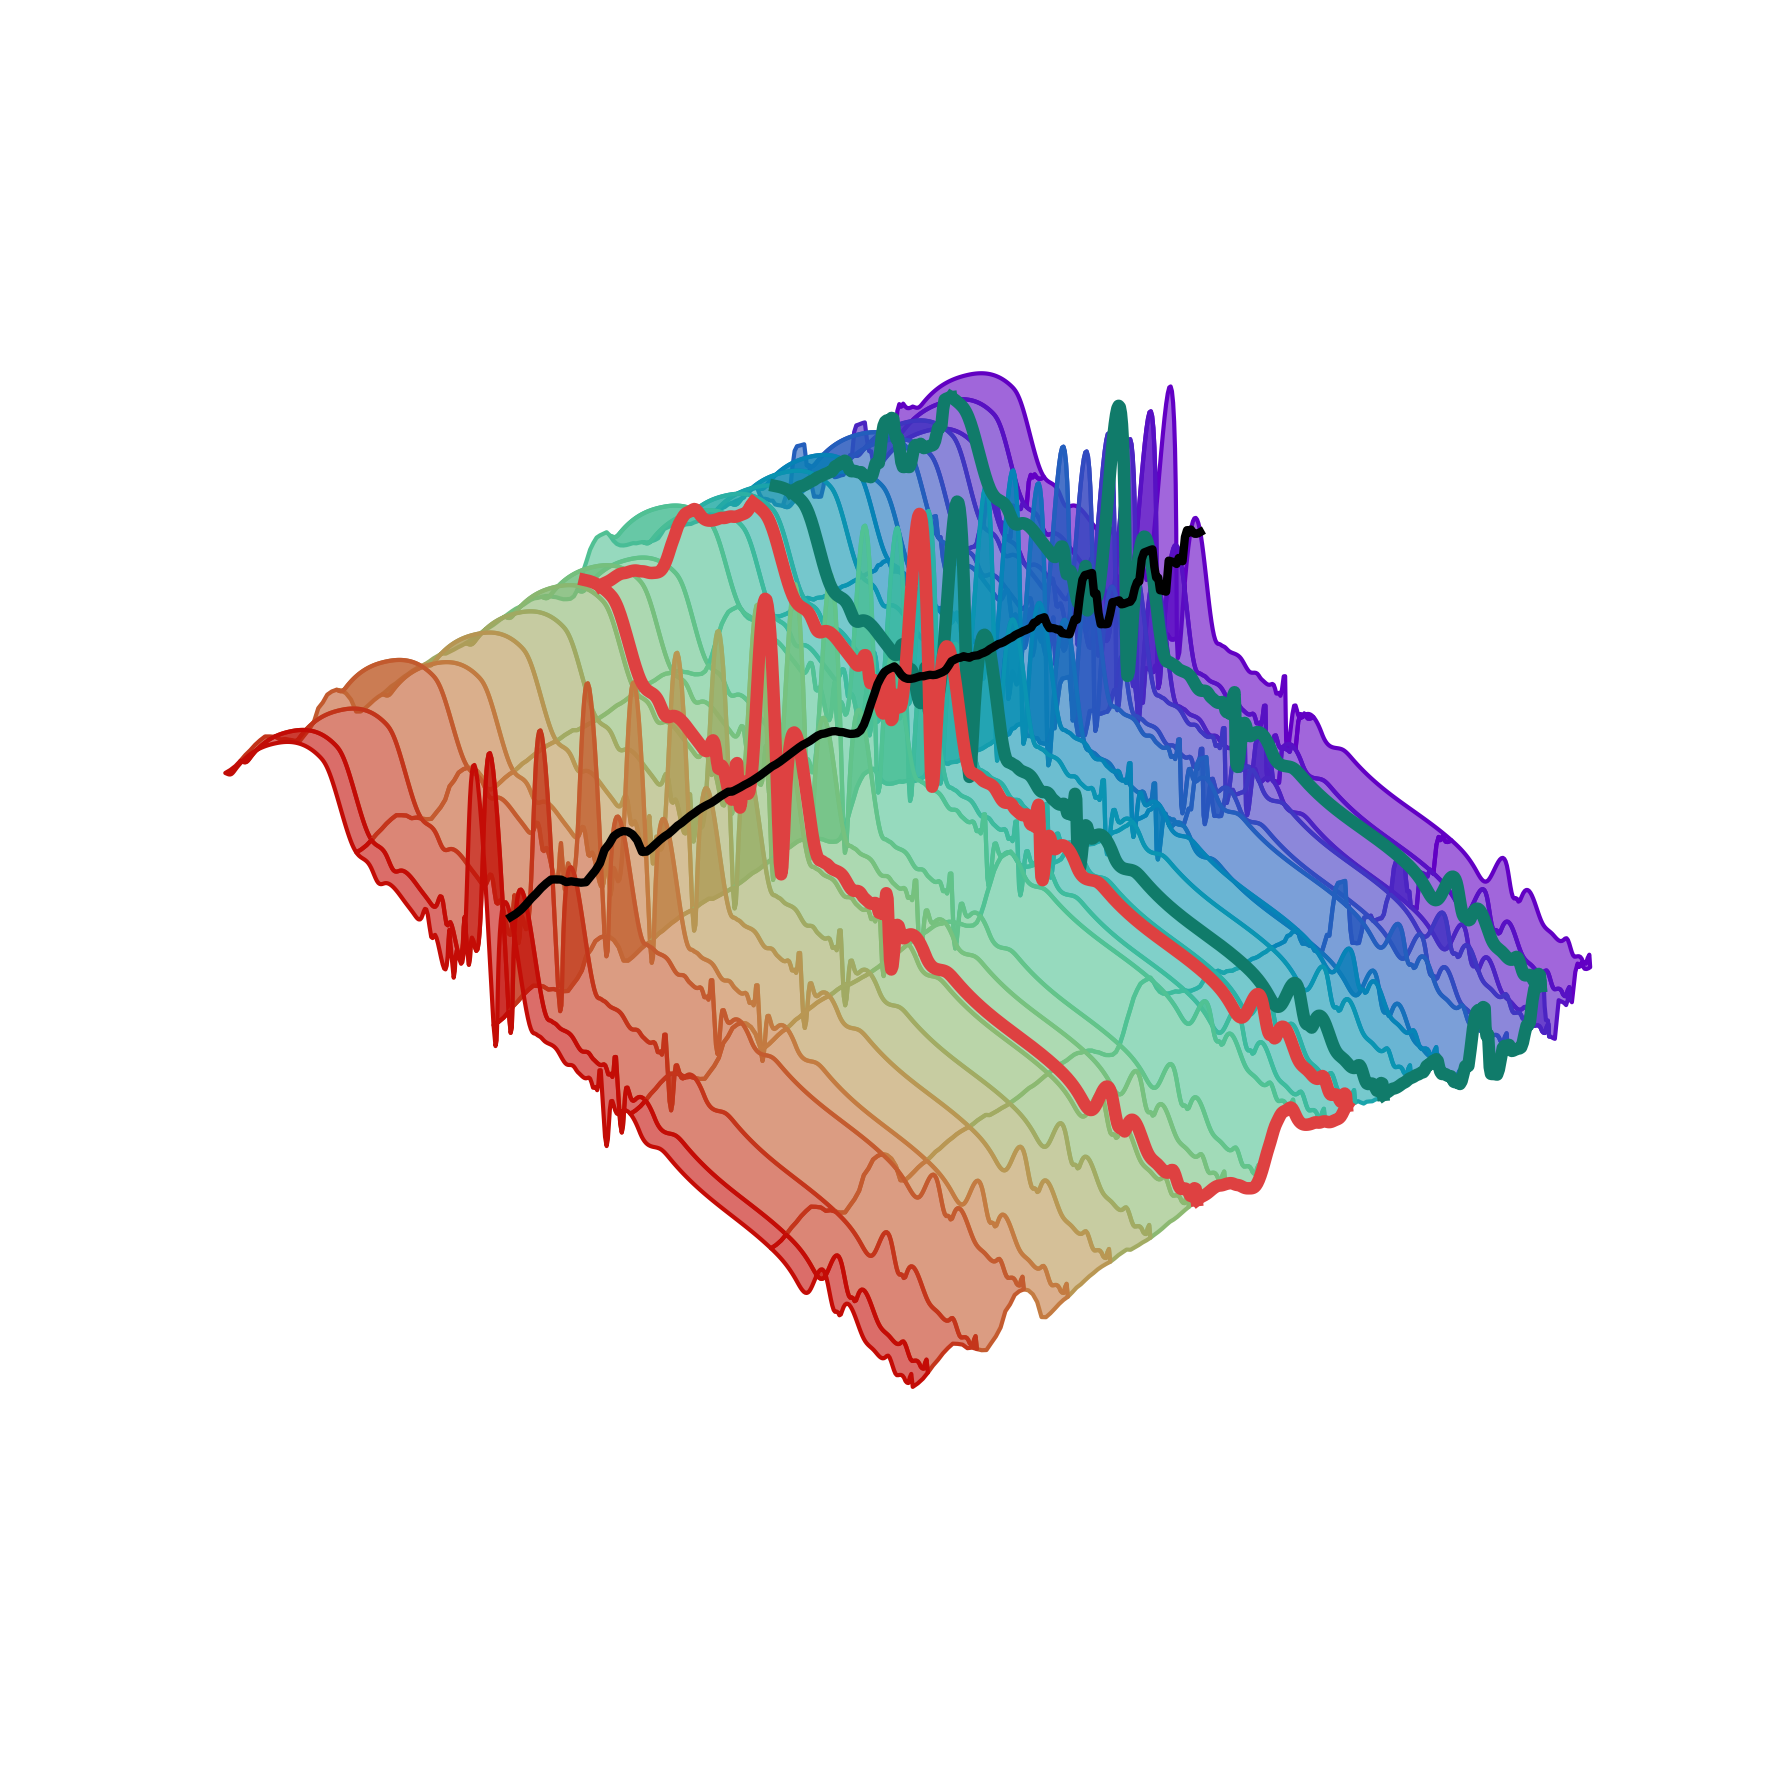

In [45]:
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.interpolate import interp1d
from tqdm import tqdm

for batch in dataset:
    mag, time, mask, magerr, spec, freq, maskspec, specerr, redshift, classification = (
        batch
    )
    if sum(mask) == 200:
        idx_sort = np.argsort(time[:100][mask[:100]])
        Rbandtime = time[:100][mask[:100]][idx_sort].numpy()
        Rbandmag = mag[:100][mask[:100]][idx_sort].numpy()
        idx_sort = np.argsort(time[100:][mask[100:]])
        gbandtime = time[100:][mask[100:]][idx_sort].numpy()
        gbandmag = mag[100:][mask[100:]][idx_sort].numpy()
        lightc_interp = interp1d(gbandtime[:], gbandmag[:], kind="cubic")

        sort_idx = np.argsort(freq[maskspec])
        freqs = freq[maskspec][sort_idx].numpy()
        specs = spec[maskspec][sort_idx].numpy()
        specs_interp = interp1d(freqs, specs, kind="cubic")
        minfreq = np.min(freq.numpy())
        maxfreq = np.max(freq.numpy())
        freqrange = maxfreq - minfreq
        # Create the plot
        fig = plt.figure(figsize=(12, 6), dpi=300)
        ax = fig.add_subplot(111, projection="3d")

        def f(x, y):
            xnorm = (x - minfreq) / freqrange
            return (0.1 * specs_interp(x) + 1) * lightc_interp(y)

        # Generate data
        x = freqs
        ys = np.linspace(10, 450, 500)
        y_2d = np.ones_like(freqs) * 200
        x_2d = np.ones_like(ys) * 4200
        x, y = np.meshgrid(x, ys)
        z = f(x, y)
        facecolors = (x - minfreq) / freqrange
        ax.set_facecolor("none")
        ax.plot_surface(
            x,
            y,
            z,
            alpha=0.6,
            facecolors=plt.cm.rainbow((x - x.min()) / (x.max() - x.min())),
            rstride=100,
            cstride=10,
            linewidth=1,
            antialiased=True,
        )
        ax.plot(freqs, y_2d, f(freqs, y_2d), color="black", linewidth=2, zorder=99)

        # gband
        glowband = 4200
        ghighband = 5500
        ys = np.linspace(70, 450, 500)
        x_2d = np.ones_like(ys) * glowband
        ax.plot(x_2d, ys, f(x_2d, ys), color="#107b6a", linewidth=3, zorder=98)
        ys = np.linspace(60, 450, 500)
        x_2d = np.ones_like(ys) * ghighband
        ax.plot(x_2d, ys, f(x_2d, ys), color="#107b6a", linewidth=3, zorder=98)
        # light colored surface
        x = np.linspace(glowband, ghighband, 500)
        ys = np.linspace(10, 450, 500)
        x, y = np.meshgrid(x, ys)
        z = f(x, y)
        for pos in np.linspace(70, 450, 2):
            x = np.linspace(glowband, ghighband, 100)
            y = np.linspace(pos, pos, 100)
            plt.plot(x, y, f(x, y), zorder=99, color="#107b6a", linewidth=3)

        # Rband
        Rlowband = 5800
        Rhighband = 7000
        ys = np.linspace(70, 450, 500)
        x_2d = np.ones_like(ys) * Rlowband
        ax.plot(x_2d, ys, f(x_2d, ys), color="#de4141", linewidth=3, zorder=98)
        ys = np.linspace(60, 450, 500)
        x_2d = np.ones_like(ys) * Rhighband
        ax.plot(x_2d, ys, f(x_2d, ys), color="#de4141", linewidth=3, zorder=98)
        # light colored surface
        x = np.linspace(Rlowband, Rhighband, 500)
        ys = np.linspace(10, 450, 500)
        x, y = np.meshgrid(x, ys)
        z = f(x, y)
        for pos in np.linspace(70, 450, 2):
            x = np.linspace(Rlowband, Rhighband, 100)
            y = np.linspace(pos, pos, 100)
            plt.plot(x, y, f(x, y), zorder=99, color="#de4141", linewidth=3)

        # Remove background grid and spines
        ax.w_xaxis.pane.fill = False
        ax.w_yaxis.pane.fill = False
        ax.w_zaxis.pane.fill = False
        ax.grid(False)
        ax.view_init(elev=35, azim=45)

        # Add labels and title
        ax.set_axis_off()
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_zlabel("")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_zlim([25, 12])

        plt.tight_layout()
        plt.savefig("3dplot.png")
        break

/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/ipykernel_18642/1431863784.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')
/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/ipykernel_18642/1431863784.py:33: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.pane.fill = False
/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/ipykernel_18642/1431863784.py:34: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.pane.fill = False
/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/ipykernel_18642/1431863784.py:35: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will

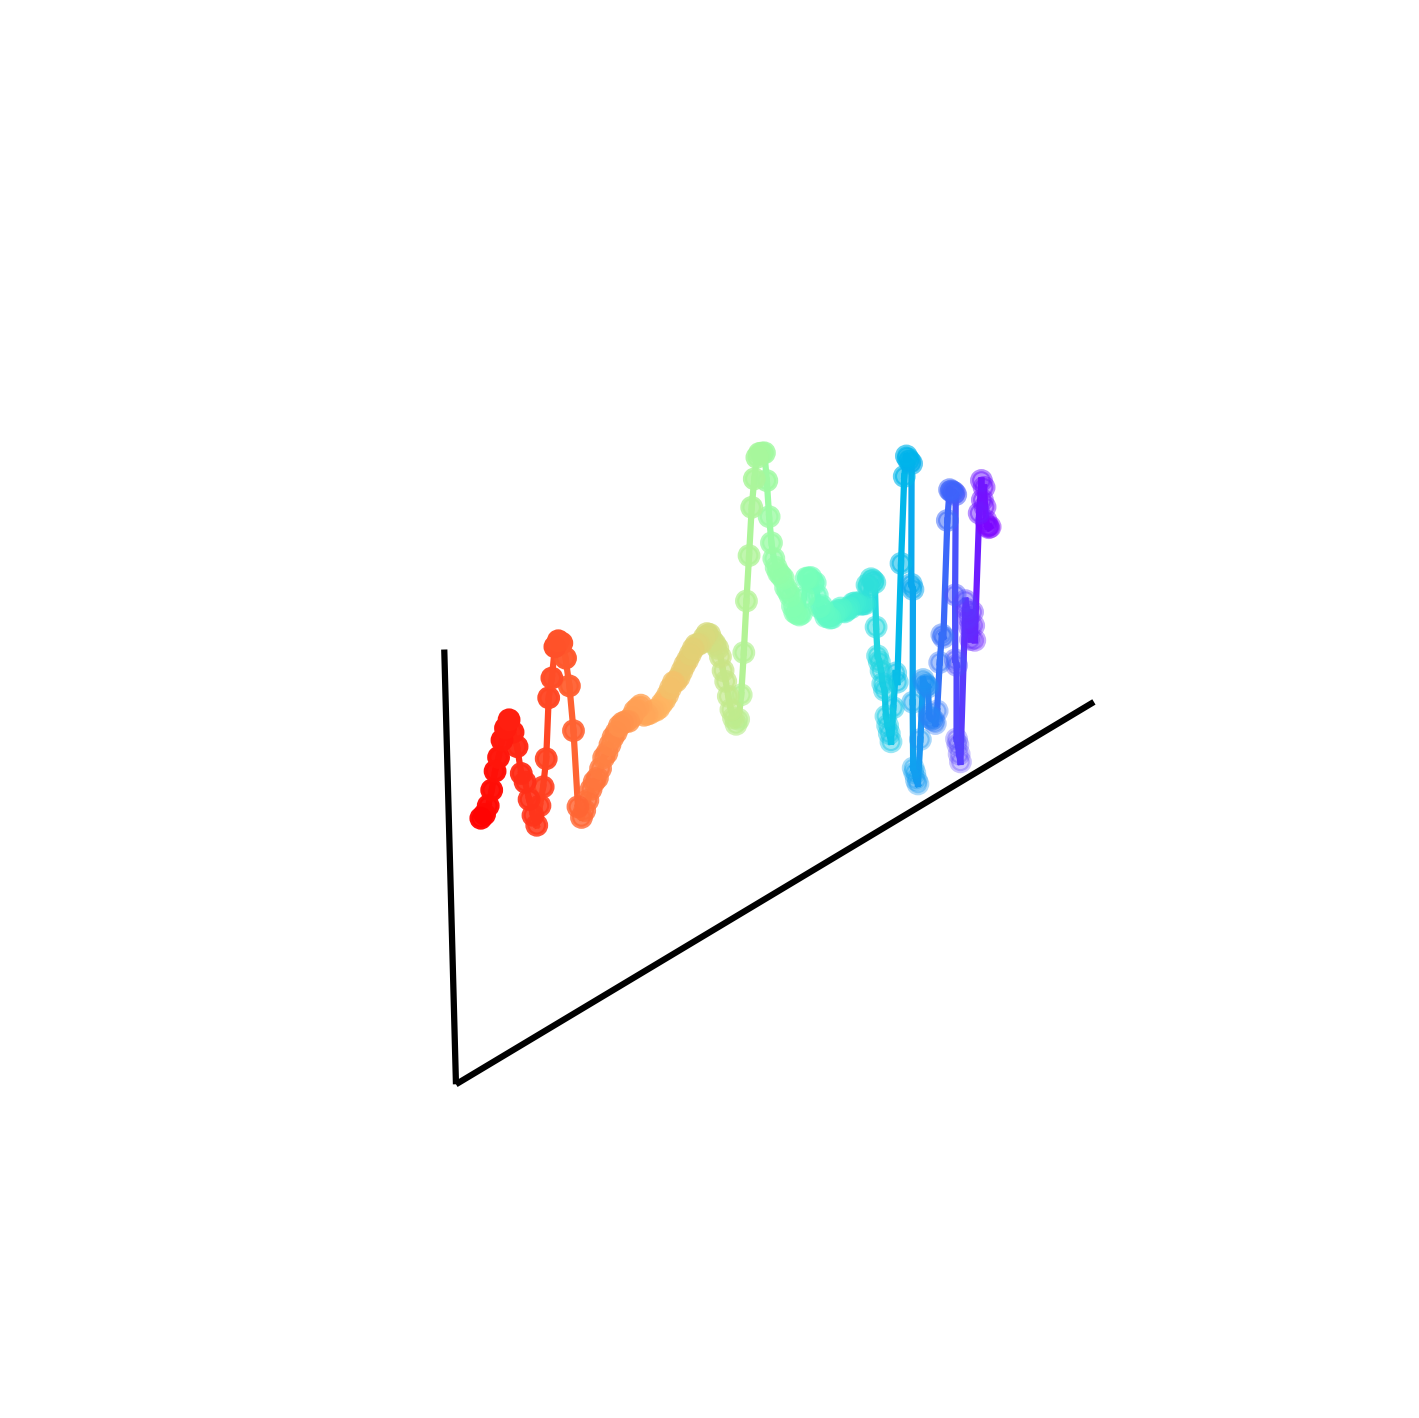

In [46]:
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

for batch in dataset:
    mag, time, mask, magerr, spec, freq, maskspec, specerr, redshift, classification = (
        batch
    )
    if sum(mask) == 200:
        fig = plt.figure(dpi=300)
        ax = fig.add_subplot(111, projection="3d")

        sort_idx = np.argsort(freq[maskspec])
        freqs = freq[maskspec][sort_idx].numpy()
        specs = spec[maskspec][sort_idx].numpy()

        # Assign colors to the data points
        colors = cmap(norm(range(len(freqs))))
        x_2d = np.zeros_like(freqs)

        norm = plt.Normalize(vmin=0, vmax=len(freqs))
        # Create a colormap
        cmap = cm.get_cmap("rainbow")
        # Assign colors to the data points
        colors = cmap(norm(range(len(freqs))))
        # axes[1].plot(freqs,specs,label = 'spectral',color=colors)
        ax.scatter(freqs, x_2d, specs, label="spectral", c=colors)
        for i in range(len(freqs) - 1):
            # axes[1].plot(freqs[i:i+2], specs[i:i+2], color=colors[i])
            ax.plot(
                freqs[i : i + 2], x_2d[i : i + 2], specs[i : i + 2], color=colors[i]
            )

        # Remove background grid and spines
        ax.w_xaxis.pane.fill = False
        ax.w_yaxis.pane.fill = False
        ax.w_zaxis.pane.fill = False
        ax.set_axis_off()
        # Add labels and title
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_zlabel("")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        # Add arrows to create the illusion of 2D plot
        ax.quiver(9500, 0, 1.05, -7000, 0, 0, color="black", arrow_length_ratio=0.0)
        ax.quiver(9500, 0, 1.05, 0, 0, -1, color="black", arrow_length_ratio=0.0)

        ax.grid(False)
        ax.view_init(elev=35, azim=45)
        ax.set_zlim([1.1, -0.1])

        plt.tight_layout()
        # plt.savefig('example_data.pdf')
        break

/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/ipykernel_18642/1146916130.py:37: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.pane.fill = False
/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/ipykernel_18642/1146916130.py:38: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.pane.fill = False
/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/ipykernel_18642/1146916130.py:39: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.pane.fill = False


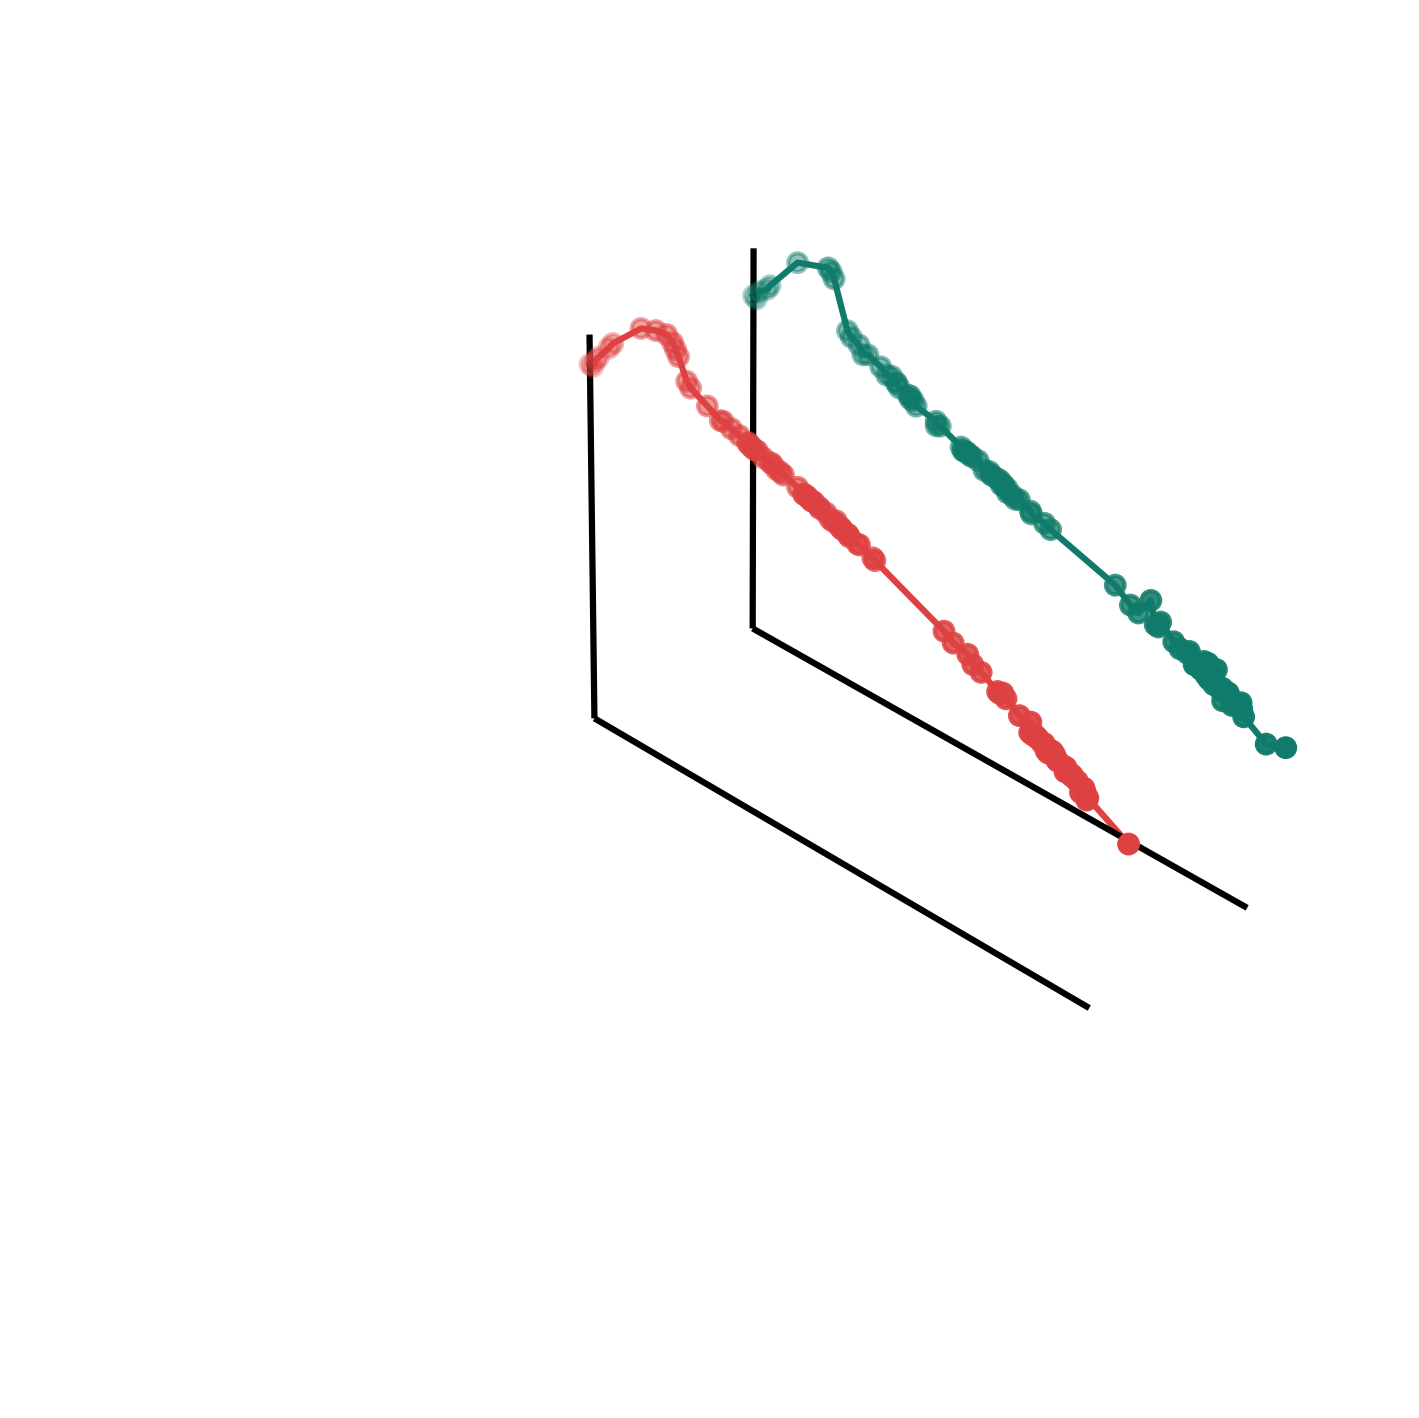

In [47]:
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

for batch in dataset:
    mag, time, mask, magerr, spec, freq, maskspec, specerr, redshift, classification = (
        batch
    )
    if sum(mask) == 200:
        fig = plt.figure(dpi=300)
        ax = fig.add_subplot(111, projection="3d")

        idx_sort = np.argsort(time[:100][mask[:100]])
        Rbandtime = time[:100][mask[:100]][idx_sort].numpy()
        Rbandmag = mag[:100][mask[:100]][idx_sort].numpy()
        idx_sort = np.argsort(time[100:][mask[100:]])
        gbandtime = time[100:][mask[100:]][idx_sort].numpy()
        gbandmag = mag[100:][mask[100:]][idx_sort].numpy()
        lightc_interp = interp1d(gbandtime[:], gbandmag[:], kind="cubic")

        # ax.plot(Rbandtime,Rbandmag,label = 'R band',color = '#de4141')
        # ax.scatter(Rbandtime,Rbandmag,color = '#de4141')
        # ax.plot(gbandtime,gbandmag,label = 'g band',color = '#107b6a')
        # ax.scatter(gbandtime,gbandmag,color = '#107b6a')
        # ax.set_xlim([0,560])

        x_2d = np.ones_like(Rbandtime) * 0.4
        ax.plot(x_2d[:-2], Rbandtime[:-2], Rbandmag[:-2], color="#de4141")
        ax.scatter(x_2d[:-2], Rbandtime[:-2], Rbandmag[:-2], color="#de4141")

        x_2d = np.ones_like(gbandtime) * 0
        ax.plot(x_2d[:-2], gbandtime[:-2], gbandmag[:-2], color="#107b6a")
        ax.scatter(x_2d[:-2], gbandtime[:-2], gbandmag[:-2], color="#107b6a")

        # Remove background grid and spines
        ax.w_xaxis.pane.fill = False
        ax.w_yaxis.pane.fill = False
        ax.w_zaxis.pane.fill = False
        ax.set_axis_off()
        # Add labels and title
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_zlabel("")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        # Add arrows to create the illusion of 2D plot
        ax.quiver(0.4, 0, 25, 0, 500, 0, color="black", arrow_length_ratio=0.0)
        ax.quiver(0.4, 0, 25, 0, 0, -10, color="black", arrow_length_ratio=0.0)

        # Add arrows to create the illusion of 2D plot
        ax.quiver(0, 0, 25, 0, 500, 0, color="black", arrow_length_ratio=0.0)
        ax.quiver(0, 0, 25, 0, 0, -10, color="black", arrow_length_ratio=0.0)

        ax.grid(False)
        ax.view_init(elev=35, azim=45)
        ax.set_zlim([25, 12])
        ax.set_xlim([0, 1.4])

        plt.tight_layout()
        # plt.savefig('example_data.pdf')
        break

In [48]:
# Assuming data is in a structured format like CSV or similar
gband = pd.read_csv("Palomar_ZTF.g.dat", delim_whitespace=True, header=None)
rband = pd.read_csv("Palomar_ZTF.r.dat", delim_whitespace=True, header=None)

/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/ipykernel_18642/115090114.py:24: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.pane.fill = False
/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/ipykernel_18642/115090114.py:25: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.pane.fill = False
/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/ipykernel_18642/115090114.py:26: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.pane.fill = False


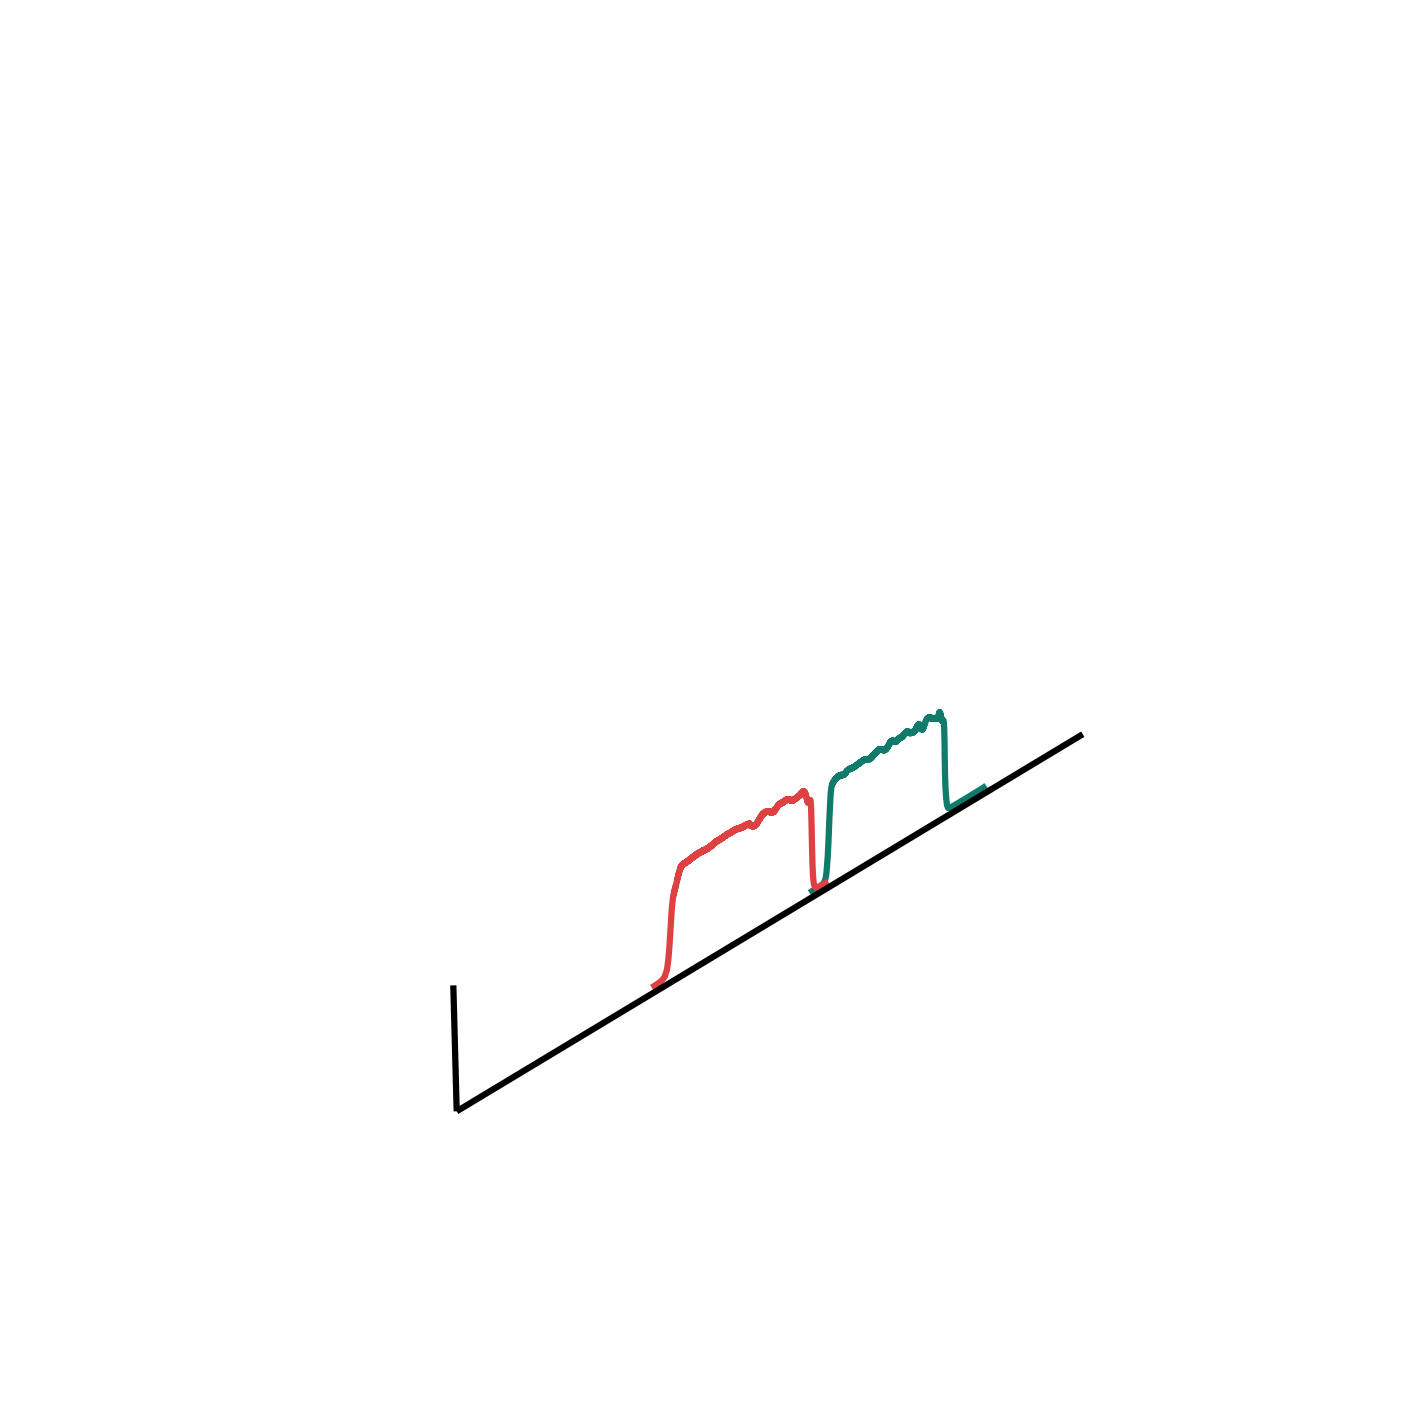

In [49]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection="3d")
# ==============================
sort_idx = np.argsort(freq[maskspec])
freqs = gband.iloc[:, 0]
specs = gband.iloc[:, 1]
# Assign colors to the data points
colors = cmap(norm(range(len(freqs))))
x_2d = np.zeros_like(freqs)
# axes[1].plot(freqs,specs,label = 'spectral',color=colors)
ax.plot(freqs, x_2d, specs, color="#107b6a")
# ==============================
freqs = rband.iloc[:, 0]
specs = rband.iloc[:, 1]
# Assign colors to the data points
colors = cmap(norm(range(len(freqs))))
x_2d = np.zeros_like(freqs)
# axes[1].plot(freqs,specs,label = 'spectral',color=colors)
ax.plot(freqs, x_2d, specs, color="#de4141")
# ==============================


# Remove background grid and spines
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.set_axis_off()
# Add labels and title
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Add arrows to create the illusion of 2D plot
ax.quiver(9500, 0, -0.05, -7000, 0, 0, color="black", arrow_length_ratio=0.0)
ax.quiver(9500, 0, -0.05, 0, 0, 1, color="black", arrow_length_ratio=0.0)

ax.grid(False)
ax.view_init(elev=35, azim=45)
ax.set_zlim([0, 4])

plt.tight_layout()

### Plotting sim data